# Thesis Topic: Supervised Criss-Cross Transformer for ECG Waveform Segmentation

## Setup

### Import Libraries & Custom Function

In [1]:
import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import math
import torch
import random
import pickle
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

print(f"[INFO] Global seed set to {SEED}")

[INFO] Global seed set to 42


In [2]:
from data import dataPipeline, isAllAnnotationValids
from dataset import buildLoaders_1Lead, buildLoaders_12Leads, saveTensorSplits, makeKFoldPatientTensors, makeKFoldPatientTensors12Leads
from models import UNet1D, CNNBiLSTM_Model_Profile11, CC_Transformer
from metrics import evalPaperMetrics
from tests import testForwardPass_UNet1D, testForwardPass_CNNBiLSTM
from utils import plotExampleWithMasks, plotLosses, saveBestModel, loadBestModel, runEpoch, runEpoch_MultiLead, plotPredsVsGt, trainKFoldGeneric

In [3]:
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

## Config

In [4]:
with open("configs.yaml", "r") as f:
    config = yaml.safe_load(f)

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current Device: {device.type.upper()}")

Current Device: CUDA


## Run Data Pipeline

In [5]:
from data import dataPipeline
rawDf, recordDf = dataPipeline()

In [6]:
recordDf = recordDf.sort_values(["record_number", "lead_index"])
recordDf[['lead_index', 'channel']].drop_duplicates().sort_values('lead_index')

,lead_index,channel
0,0,i
1,1,ii
2,2,iii
3,3,avr
4,4,avl
5,5,avf
6,6,v1
7,7,v2
8,8,v3
9,9,v4


In [7]:
recordDf.head(5)

,record_number,channel,fs,lead_index,signal,signal_length,annotation,samples,num_annotations,label_fidu,label_wave
0,1,i,500,0,"[-0.07342657342657342, -0.028554778554778556, ...",5000,"[(, N, ), (, t, ), (, p, ), (, N, ), (, t, ), ...","[641, 664, 690, 773, 840, 887, 1252, 1282, 130...",48,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,ii,500,1,"[0.019071310116086235, 0.07877280265339967, 0....",5000,"[(, N, ), (, t, ), (, p, ), (, N, ), (, t, ), ...","[644, 662, 682, 776, 843, 878, 1250, 1278, 130...",48,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,iii,500,2,"[0.12205044751830757, 0.11798209926769732, 0.1...",5000,"[(, N, ), (, t, ), (, p, ), (, N, ), (, t, ), ...","[633, 666, 682, 782, 834, 867, 1271, 1288, 130...",48,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,avr,500,3,"[0.038011695906432746, -0.01608187134502924, -...",5000,"[(, N, ), (, t, ), (, p, ), (, N, ), (, t, ), ...","[642, 650, 689, 775, 841, 876, 1251, 1280, 130...",48,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,avl,500,4,"[-0.10014619883040936, -0.07017543859649122, -...",5000,"[(, N, ), (, t, ), (, p, ), (, N, ), (, t, ), ...","[646, 665, 681, 783, 838, 880, 1257, 1285, 130...",48,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Make Tensor Dataset

In [8]:
# Tensor dataloaders (1 Lead)
fixedTensors = buildLoaders_1Lead(recordDf, fs = 500, split = (0.8, 0.1, 0.1))
saveTensorSplits(fixedTensors, cacheDir = config['paths']['data_dir'] + "fixed/", prefix = 'fixed')

# Tensor dataloaders (Stacked Leads)
fixedTensors = buildLoaders_12Leads(recordDf, fs = 500, trimSeconds = 1.0, split = (0.8, 0.1, 0.1))
saveTensorSplits(fixedTensors, cacheDir = config['paths']['data_dir'] + "fixed/", prefix = 'fixed_12Leads')

# Tensor dataloaders (Stacked Leads)
fixedTensors = buildLoaders_12Leads(recordDf, fs = 500, trimSeconds = 1.0, split = (0.8, 0.1, 0.1), sortOn = "channel")
saveTensorSplits(fixedTensors, cacheDir = config['paths']['data_dir'] + "fixed/", prefix = 'fixed_12Leads_sortedOn_channels')

### Plot an example

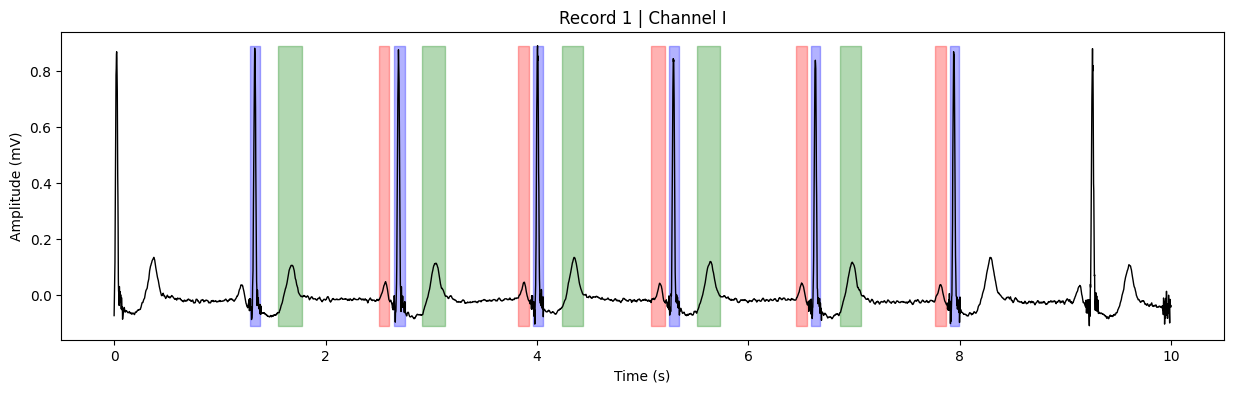

In [9]:
plotExampleWithMasks(recordDf, recordNumber = 1, channel = 'i')

## U-Net

In [10]:
# Sanity Check
testForwardPass_UNet1D()

Input shape:  torch.Size([2, 1, 2000])
Output shape: torch.Size([2, 4, 2000])
For 1D U-Net model! Forward pass test passed!


In [11]:
# Load cached tensors
cache_dir = config['paths']['data_dir'] + "fixed/"
train_X = torch.load(cache_dir + "fixed_train_X.pt", weights_only = False)
train_y = torch.load(cache_dir + "fixed_train_y.pt", weights_only = False)

xb = train_X[0:1]   # shape: (1, C, L)
yb = train_y[0:1]   # shape: (1, C, L)
# Move to GPU if available
xb, yb = xb.to(device), yb.to(device)

# Model
torch.manual_seed(SEED)  # re-seed right before model init
model = UNet1D(input_channels = 1, num_classes = 4).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# Overfit loop
epochs = 50
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    outputs = model(xb)  # shape: (B, C, L)
    loss = criterion(outputs, yb)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.6f}")
print("Overfit-one-batch test complete ✅")

Epoch 1/50 - Loss: 1.574221
Epoch 5/50 - Loss: 1.400130
Epoch 10/50 - Loss: 1.346491
Epoch 15/50 - Loss: 1.316523
Epoch 20/50 - Loss: 1.280463
Epoch 25/50 - Loss: 1.234569
Epoch 30/50 - Loss: 1.202769
Epoch 35/50 - Loss: 1.181703
Epoch 40/50 - Loss: 1.165137
Epoch 45/50 - Loss: 1.150371
Epoch 50/50 - Loss: 1.137300
Overfit-one-batch test complete ✅


In [12]:
# Load data
cache_dir = config['paths']['data_dir'] + "fixed/"
train_X = torch.load(cache_dir + "fixed_train_X.pt", weights_only = False)
train_y = torch.load(cache_dir + "fixed_train_y.pt", weights_only = False)
val_X = torch.load(cache_dir + "fixed_val_X.pt", weights_only = False)
val_y = torch.load(cache_dir + "fixed_val_y.pt", weights_only = False)

# Dataloaders
trainLoader = DataLoader(TensorDataset(train_X, train_y), batch_size = 16, shuffle = False)
valLoader = DataLoader(TensorDataset(val_X, val_y), batch_size = 16, shuffle = False)

# Model/Loss/Optimizer
torch.manual_seed(SEED)  # re-seed right before model init
model = UNet1D(input_channels = 1, num_classes = 4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Training Loop
epochs = 2  # smoke run
for epoch in range(1, epochs + 1):
    model.train()
    trainLoss = 0.0

    for xb, yb in trainLoader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        trainLoss += loss.item() * xb.size(0)

    # Validation
    model.eval()
    valLoss = 0.0
    with torch.no_grad():
        for xb, yb in valLoader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            valLoss += loss.item() * xb.size(0)

    print(f"Epoch {epoch}/{epochs} "
          f"- Train Loss: {trainLoss / len(trainLoader.dataset):.4f} "
          f"- Val Loss: {valLoss / len(valLoader.dataset):.4f}")

Epoch 1/2 - Train Loss: 1.1720 - Val Loss: 0.9931
Epoch 2/2 - Train Loss: 0.8695 - Val Loss: 0.8034


## CNN + BiLSTM

In [13]:
# Sanity Check
testForwardPass_CNNBiLSTM()

Input shape:  torch.Size([2, 1, 2000])
Output shape: torch.Size([2, 4, 2000])
For CNN+BiLSTM hybrid model! Forward pass test passed!


In [14]:
# Load cached tensors
cache_dir = config['paths']['data_dir'] + "fixed/"
train_X = torch.load(cache_dir + "fixed_train_X.pt", weights_only = False)
train_y = torch.load(cache_dir + "fixed_train_y.pt", weights_only = False)

xb = train_X[0:1]   # shape: (1, C, L)
yb = train_y[0:1]   # shape: (1, C, L)
# Move to GPU if available
xb, yb = xb.to(device), yb.to(device)

# Model
torch.manual_seed(SEED)  # re-seed right before model init
model = CNNBiLSTM_Model_Profile11(input_channels = 1, num_classes = 4).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-5)

# Overfit loop
epochs = 50
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    outputs = model(xb)  # shape: (B, C, L)
    loss = criterion(outputs, yb)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.6f}")
print("Overfit-one-batch test complete ✅")

Epoch 1/50 - Loss: 1.394346
Epoch 5/50 - Loss: 1.392009
Epoch 10/50 - Loss: 1.389101
Epoch 15/50 - Loss: 1.386181
Epoch 20/50 - Loss: 1.383248
Epoch 25/50 - Loss: 1.380287
Epoch 30/50 - Loss: 1.377294
Epoch 35/50 - Loss: 1.374267
Epoch 40/50 - Loss: 1.371196
Epoch 45/50 - Loss: 1.368072
Epoch 50/50 - Loss: 1.364892
Overfit-one-batch test complete ✅


In [15]:
# Load data
cache_dir = config['paths']['data_dir'] + "fixed/"
train_X = torch.load(cache_dir + "fixed_train_X.pt", weights_only = False)
train_y = torch.load(cache_dir + "fixed_train_y.pt", weights_only = False)
val_X = torch.load(cache_dir + "fixed_val_X.pt", weights_only = False)
val_y = torch.load(cache_dir + "fixed_val_y.pt", weights_only = False)

# Dataloaders
trainLoader = DataLoader(TensorDataset(train_X, train_y), batch_size = 8, shuffle = False)
valLoader = DataLoader(TensorDataset(val_X, val_y), batch_size = 8, shuffle = False)

# Model/Loss/Optimizer
torch.manual_seed(SEED)  # re-seed right before model init
model = CNNBiLSTM_Model_Profile11(input_channels = 1, num_classes = 4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Training Loop
epochs = 2  # smoke run
for epoch in range(1, epochs + 1):
    model.train()
    trainLoss = 0.0

    count = 0
    for xb, yb in trainLoader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        trainLoss += loss.item() * xb.size(0)
    
    # Validation
    model.eval()
    valLoss = 0.0
    with torch.no_grad():
        for xb, yb in valLoader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            valLoss += loss.item() * xb.size(0)

    print(f"Epoch {epoch}/{epochs} "
          f"- Train Loss: {trainLoss / len(trainLoader.dataset):.4f} "
          f"- Val Loss: {valLoss / len(valLoader.dataset):.4f}")

Epoch 1/2 - Train Loss: 0.7868 - Val Loss: 0.5637
Epoch 2/2 - Train Loss: 0.5121 - Val Loss: 0.3273


## Full Training (All 5 Models) - Fixed Split

### Load Fixed dataset for U-Net/CNN+BiLSTM

In [16]:
# Load data
cache_dir = config['paths']['data_dir'] + "fixed/"
fixed_train_X = torch.load(cache_dir + "fixed_train_X.pt", weights_only = False)
fixed_train_y = torch.load(cache_dir + "fixed_train_y.pt", weights_only = False)
fixed_val_X = torch.load(cache_dir + "fixed_val_X.pt", weights_only = False)
fixed_val_y = torch.load(cache_dir + "fixed_val_y.pt", weights_only = False)
fixed_test_X = torch.load(cache_dir + "fixed_test_X.pt", weights_only = False)
fixed_test_y = torch.load(cache_dir + "fixed_test_y.pt", weights_only = False)

trainDS = TensorDataset(fixed_train_X, fixed_train_y)
valDS = TensorDataset(fixed_val_X, fixed_val_y)
testDS = TensorDataset(fixed_test_X, fixed_test_y)

trainLoader_1Lead = DataLoader(trainDS, batch_size = 8, shuffle = False)
valLoader_1Lead = DataLoader(valDS, batch_size = 8, shuffle = False)
testLoader_1Lead = DataLoader(testDS, batch_size = 8, shuffle = False)

### Load Fixed dataset for CCT

In [17]:
# Load data
cache_dir = config['paths']['data_dir'] + "fixed/"
fixed_train_X = torch.load(cache_dir + "fixed_12Leads_train_X.pt", weights_only = False)
fixed_train_y = torch.load(cache_dir + "fixed_12Leads_train_y.pt", weights_only = False)
fixed_val_X = torch.load(cache_dir + "fixed_12Leads_val_X.pt", weights_only = False)
fixed_val_y = torch.load(cache_dir + "fixed_12Leads_val_y.pt", weights_only = False)
fixed_test_X = torch.load(cache_dir + "fixed_12Leads_test_X.pt", weights_only = False)
fixed_test_y = torch.load(cache_dir + "fixed_12Leads_test_y.pt", weights_only = False)

trainDS = TensorDataset(fixed_train_X, fixed_train_y)
valDS = TensorDataset(fixed_val_X, fixed_val_y)
testDS = TensorDataset(fixed_test_X, fixed_test_y)

trainLoader_12Leads = DataLoader(trainDS, batch_size = 8, shuffle = False)
valLoader_12Leads = DataLoader(valDS, batch_size = 8, shuffle = False)
testLoader_12Leads = DataLoader(testDS, batch_size = 8, shuffle = False)


fixed_test_X_sortedOn_channels = torch.load(cache_dir + "fixed_12Leads_sortedOn_channels_test_X.pt", weights_only = False)
fixed_test_y_sortedOn_channels = torch.load(cache_dir + "fixed_12Leads_sortedOn_channels_test_y.pt", weights_only = False)

testDS = TensorDataset(fixed_test_X_sortedOn_channels, fixed_test_y_sortedOn_channels)
testLoader_12Leads_sortedOn_Channels = DataLoader(testDS, batch_size = 8, shuffle = False)

### On UNet1D -- Train/Val/Test - 160/20/20

In [18]:
# Model
torch.manual_seed(SEED)  # re-seed right before model init
model_UNet1D = UNet1D(input_channels = 1, num_classes = 4).to(device)

# Number of Parameters
numParams = sum(p.numel() for p in model_UNet1D.parameters())
print(f"Number of total parameters for U-Net Model: {numParams}")

# Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_UNet1D.parameters(), lr = 0.0001)

# Train
trainLosses_UNet1D, valLosses_UNet1D = [], []
bestVal, bestEp, bestState = float("inf"), 0, None
epochs = 50
for ep in range(1, epochs + 1):
    trainLoss, trainAcc = runEpoch(model_UNet1D, trainLoader_1Lead, criterion, optimizer, 'cuda')
    valLoss, valAcc = runEpoch(model_UNet1D, valLoader_1Lead, criterion, None, 'cuda')

    trainLosses_UNet1D.append(trainLoss)
    valLosses_UNet1D.append(valLoss)

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d} | train {trainLoss:.4f}/{trainAcc:.3f} | "f"val {valLoss:.4f}/{valAcc:.3f}")

    # keep best by val loss
    if valLoss < bestVal - 1e-4:
        bestVal, bestEp = valLoss, ep
        bestState = {k: v.detach().cpu() for k, v in model_UNet1D.state_dict().items()}

# Load best & Test
if bestState is not None:
    model_UNet1D.load_state_dict(bestState)
    saveBestModel(bestState, config['paths']['checkpoints_dir'] + "UNet1D_best.pt", epoch = bestEp, val_loss = bestVal)

testLoss, testAcc = runEpoch(model_UNet1D, testLoader_1Lead, criterion, None, 'cuda')
print(f"BEST @ epoch {bestEp} | val_loss = {bestVal:.4f}")
print(f"TEST | loss {testLoss:.4f} | acc {testAcc:.3f}")

Number of total parameters for U-Net Model: 167344


/home/gaurav/ECG_Segmentation/utils.py:166: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  totalLoss += float(loss) * n_tok


Epoch 01 | train 1.3547/0.201 | val 1.2792/0.180
Epoch 05 | train 0.9589/0.831 | val 0.9815/0.827
Epoch 10 | train 0.6823/0.908 | val 0.6809/0.908
Epoch 15 | train 0.3384/0.932 | val 0.3887/0.911
Epoch 20 | train 0.2109/0.941 | val 0.2981/0.911
Epoch 25 | train 0.1570/0.949 | val 0.2739/0.912
Epoch 30 | train 0.1321/0.953 | val 0.2720/0.912
Epoch 35 | train 0.1169/0.957 | val 0.2799/0.912
Epoch 40 | train 0.1050/0.960 | val 0.2944/0.910
Epoch 45 | train 0.0997/0.961 | val 0.3012/0.912
Epoch 50 | train 0.0910/0.964 | val 0.3228/0.909
BEST @ epoch 27 | val_loss = 0.2674
TEST | loss 0.2550 | acc 0.916


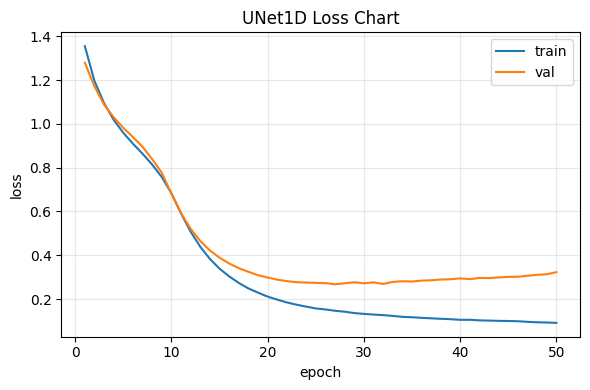

In [19]:
plotLosses(
    trainLosses_UNet1D, valLosses_UNet1D,
    title = "UNet1D Loss Chart", save_path = config['paths']['results_dir'] + 'UNet1D_1Lead_loss.png'
)

In [20]:
pd.DataFrame(evalPaperMetrics(model_UNet1D, testLoader_1Lead, fs = 500, tolerance = 150, device = 'cuda'))

,P_on,P_off,QRS_on,QRS_off,T_on,T_off
m,0.026303,1.464686,-0.685388,0.370338,0.537981,1.164021
σ,6.885840,7.689375,3.087251,4.543169,11.697695,11.407344
Se,0.996118,0.996118,0.999561,0.999561,0.990476,0.990000
PPV,0.873617,0.873617,0.957161,0.957161,0.856672,0.856260
F1,0.930855,0.930855,0.977902,0.977902,0.918728,0.918286


In [21]:
# Grab the signal
sig = recordDf[(recordDf['record_number'] == 181) & (recordDf['channel'] == 'ii')]['signal'].iat[0][500:4500]

# to tensor [B=1, C=1, T]
xb = torch.as_tensor(sig, dtype = torch.float32, device = device).unsqueeze(0).unsqueeze(0)

# run model -> logits [1, 4, L] -> preds [L]
model_UNet1D.eval()
with torch.no_grad():
    logits = model_UNet1D(xb)
preds = logits.argmax(1).squeeze(0)  # tensor of class ids per timestep

In [22]:
# Ensure 2D
if preds.dim() == 1:  # (T,) -> (1, T)
    preds = preds.unsqueeze(0)

C, T = preds.shape
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)  # pad along time
predsPadded.shape

torch.Size([1, 5000])

token-acc: 0.909


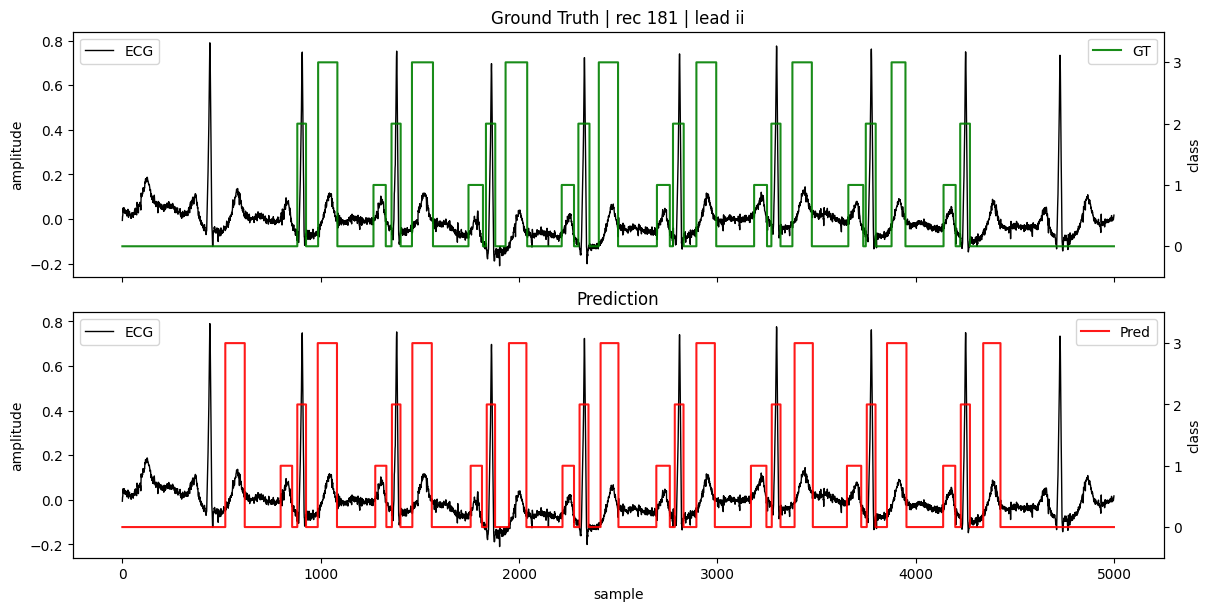

(0.9093999862670898, './results/UNet1D_Patient_181_Lead_II_split.png')

In [23]:
plotPredsVsGt(predsPadded[0], recordDf, 181, 'ii', config, modelName = "UNet1D")

In [24]:
# Grab the signal
sig = recordDf[(recordDf['record_number'] == 191) & (recordDf['channel'] == 'i')]['signal'].iat[0][500:4500]

# to tensor [B=1, C=1, T]
xb = torch.as_tensor(sig, dtype = torch.float32, device = device).unsqueeze(0).unsqueeze(0)

# run model -> logits [1, 4, L] -> preds [L]
model_UNet1D.eval()
with torch.no_grad():
    logits = model_UNet1D(xb)
preds = logits.argmax(1).squeeze(0)  # tensor of class ids per timestep

In [25]:
# Ensure 2D
if preds.dim() == 1:  # (T,) -> (1, T)
    preds = preds.unsqueeze(0)

C, T = preds.shape
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)  # pad along time
predsPadded.shape

torch.Size([1, 5000])

token-acc: 0.939


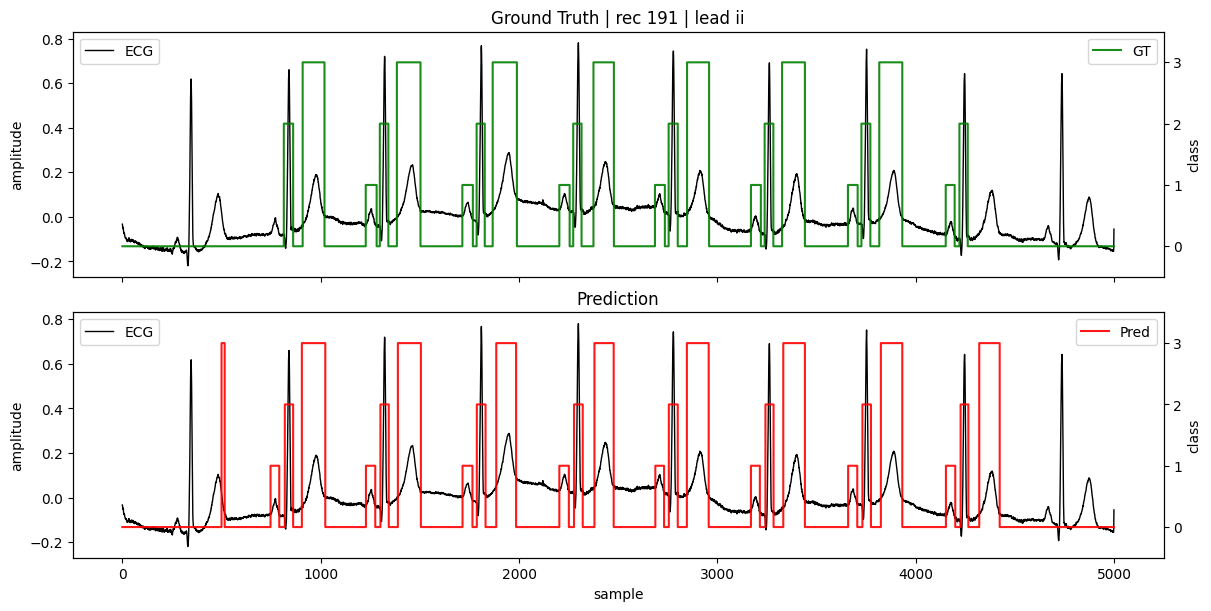

(0.9391999840736389, './results/UNet1D_Patient_191_Lead_II_split.png')

In [26]:
plotPredsVsGt(predsPadded[0], recordDf, 191, 'ii', config, modelName = "UNet1D")

### On U-Net (Multi-Leads data) -- Train/Val/Test - 160/20/20

In [27]:
# Model
torch.manual_seed(SEED)  # re-seed right before model init
multiLead_model_UNet1D = UNet1D(input_channels = 12, num_classes = 4).to(device)

# Number of Parameters
numParams = sum(p.numel() for p in multiLead_model_UNet1D.parameters())
print(f"Number of total parameters for U-Net Model: {numParams}")

# Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(multiLead_model_UNet1D.parameters(), lr = 0.0001)

# Train
trainLosses_multiLead_UNet1D, valLosses_multiLead_UNet1D = [], []
bestVal, bestEp, bestState = float("inf"), 0, None
epochs = 50
for ep in range(1, epochs + 1):
    trainLoss, trainAcc = runEpoch_MultiLead(multiLead_model_UNet1D, trainLoader_12Leads, criterion, optimizer, 'cuda')
    valLoss, valAcc = runEpoch_MultiLead(multiLead_model_UNet1D, valLoader_12Leads, criterion, None, 'cuda')

    trainLosses_multiLead_UNet1D.append(trainLoss)
    valLosses_multiLead_UNet1D.append(valLoss)

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d} | train {trainLoss:.4f}/{trainAcc:.3f} | "f"val {valLoss:.4f}/{valAcc:.3f}")

    # keep best by val loss
    if valLoss < bestVal - 1e-4:
        bestVal, bestEp = valLoss, ep
        bestState = {k: v.detach().cpu() for k, v in multiLead_model_UNet1D.state_dict().items()}

# Load best & Test
if bestState is not None:
    multiLead_model_UNet1D.load_state_dict(bestState)
    saveBestModel(bestState, config['paths']['checkpoints_dir'] + "MultiLead_UNet1D_best.pt", epoch = bestEp, val_loss = bestVal)

testLoss, testAcc = runEpoch_MultiLead(multiLead_model_UNet1D, testLoader_12Leads, criterion, None, 'cuda')
print(f"BEST @ epoch {bestEp} | val_loss = {bestVal:.4f}")
print(f"TEST | loss {testLoss:.4f} | acc {testAcc:.3f}")

Number of total parameters for U-Net Model: 167960
Epoch 01 | train 1.4796/0.205 | val 1.4410/0.189
Epoch 05 | train 1.4233/0.255 | val 1.4228/0.259
Epoch 10 | train 1.3640/0.272 | val 1.3591/0.274
Epoch 15 | train 1.3271/0.329 | val 1.3342/0.328
Epoch 20 | train 1.2936/0.349 | val 1.2921/0.354
Epoch 25 | train 1.2635/0.371 | val 1.2591/0.372
Epoch 30 | train 1.2344/0.400 | val 1.2334/0.396
Epoch 35 | train 1.2036/0.490 | val 1.2081/0.492
Epoch 40 | train 1.1739/0.523 | val 1.1758/0.514
Epoch 45 | train 1.1438/0.539 | val 1.1505/0.529
Epoch 50 | train 1.1130/0.551 | val 1.1206/0.539
BEST @ epoch 50 | val_loss = 1.1206
TEST | loss 1.1278 | acc 0.536


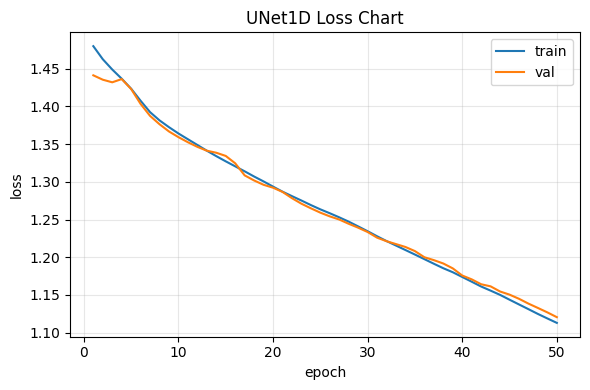

In [28]:
plotLosses(
    trainLosses_multiLead_UNet1D, valLosses_multiLead_UNet1D,
    title = "UNet1D Loss Chart", save_path = config['paths']['results_dir'] + 'UNet1D_12Leads_loss.png'
)

In [29]:
pd.DataFrame(evalPaperMetrics(multiLead_model_UNet1D, testLoader_12Leads, fs = 500, tolerance = 150, device = 'cuda'))

,P_on,P_off,QRS_on,QRS_off,T_on,T_off
m,-15.995392,-3.525621,7.905579,21.413554,25.515416,0.673102
σ,35.361139,33.265065,23.947876,26.828903,26.051269,18.434655
Se,0.526443,0.624939,0.817544,0.821930,0.818571,0.740000
PPV,0.173406,0.205849,0.241827,0.243124,0.274294,0.247966
F1,0.260880,0.309690,0.373248,0.375250,0.410900,0.371459


In [30]:
recordNumber = 181

# Pull all rows for this record_number, sort by lead_index.
rec = recordDf[recordDf['record_number'] == recordNumber]
rec = rec.sort_values('lead_index' if 'lead_index' in rec.columns else 'channel')
assert not rec.empty, f"No rows for record_number = {recordNumber}"

# Stack to [C, T]
signals = [np.asarray(s, dtype = np.float32) for s in rec['signal'].tolist()]
tRef = len(signals[0])
assert all(len(s) == tRef for s in signals), "Inconsistent lead lengths across channels."

# Remove first and last 1 second (assumes ~10 s total → cut = T//10)
cut = tRef // 10
lo, hi = cut, tRef - cut
# [C, T'] with 1–9 s kept
signals = [s[lo:hi] for s in signals]

# [C, T']
X = np.stack(signals, axis = 0)
# [1, C, T']
xb = torch.from_numpy(X).to(device = device, dtype = torch.float32).unsqueeze(0)

# Run model
multiLead_model_UNet1D.eval()
with torch.no_grad():
    # [1, K, T']
    logits = multiLead_model_UNet1D(xb)

# Per-lead vs fused handling
if logits.dim() == 4:
    # logits: [B, C, K, T′]  -> preds: [C, T′]
    preds = logits.argmax(2).squeeze(0)
else:
    # logits: [B, K, T′]     -> preds: [T′]
    preds = logits.argmax(dim = 1).squeeze(0)

In [31]:
C = preds.size(0)
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)
predsPadded.shape

torch.Size([12, 5000])

token-acc: 0.251


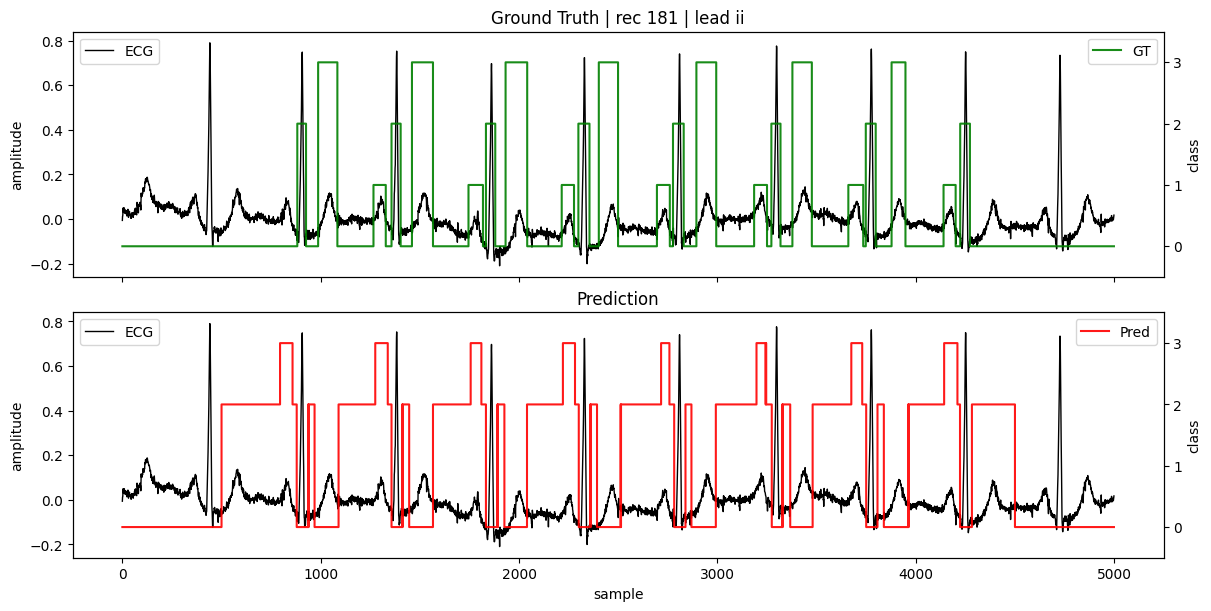

(0.2505999803543091,
 './results/UNet1D_Multi_Lead_Patient_181_Lead_II_split.png')

In [32]:
plotPredsVsGt(predsPadded[1], recordDf, 181, 'ii', config, modelName = "UNet1D_Multi_Lead")

In [33]:
recordNumber = 191

# Pull all rows for this record_number, sort by lead_index.
rec = recordDf[recordDf['record_number'] == recordNumber]
rec = rec.sort_values('lead_index' if 'lead_index' in rec.columns else 'channel')
assert not rec.empty, f"No rows for record_number = {recordNumber}"

# Stack to [C, T]
signals = [np.asarray(s, dtype = np.float32) for s in rec['signal'].tolist()]
tRef = len(signals[0])
assert all(len(s) == tRef for s in signals), "Inconsistent lead lengths across channels."

# Remove first and last 1 second (assumes ~10 s total → cut = T//10)
cut = tRef // 10
lo, hi = cut, tRef - cut
# [C, T'] with 1–9 s kept
signals = [s[lo:hi] for s in signals]

# [C, T']
X = np.stack(signals, axis = 0)
# [1, C, T']
xb = torch.from_numpy(X).to(device = device, dtype = torch.float32).unsqueeze(0)

# Run model
multiLead_model_UNet1D.eval()
with torch.no_grad():
    # [1, K, T']
    logits = multiLead_model_UNet1D(xb)

# Per-lead vs fused handling
if logits.dim() == 4:
    # logits: [B, C, K, T′]  -> preds: [C, T′]
    preds = logits.argmax(2).squeeze(0)
else:
    # logits: [B, K, T′]     -> preds: [T′]
    preds = logits.argmax(dim = 1).squeeze(0)

In [34]:
C = preds.size(0)
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)
predsPadded.shape

torch.Size([12, 5000])

token-acc: 0.262


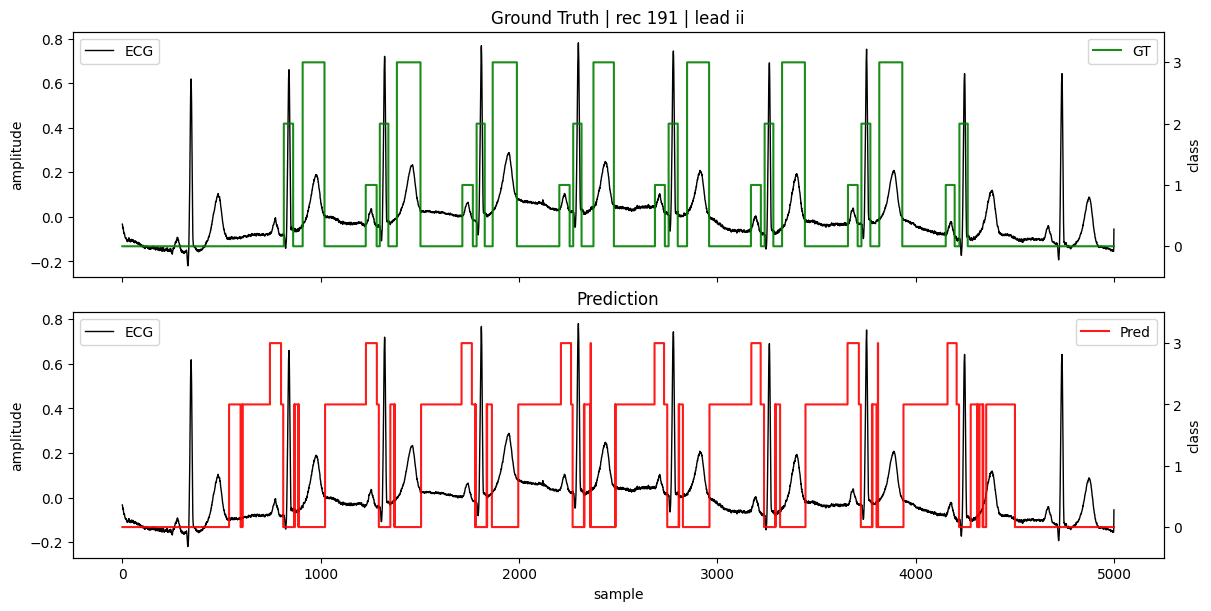

(0.2624000012874603,
 './results/UNet1D_Multi_Lead_Patient_191_Lead_II_split.png')

In [35]:
plotPredsVsGt(predsPadded[1], recordDf, 191, 'ii', config, modelName = "UNet1D_Multi_Lead")

### On CNN + BiLSTM -- Train/Val/Test - 160/20/20

In [36]:
# Model
torch.manual_seed(SEED)  # re-seed right before model init
model_CNNBiLSTM = CNNBiLSTM_Model_Profile11(input_channels = 1, num_classes = 4, lstm_hidden = 128, lstm_layers = 1).to(device)

# Number of Parameters
numParams = sum(p.numel() for p in model_CNNBiLSTM.parameters())
print(f"Number of total parameters for CNN+BiLSTM Model: {numParams}")

# Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNNBiLSTM.parameters(), lr = 0.0001)

# Train
trainLosses_CNNBiLSTM, valLosses_CNNBiLSTM = [], []
bestVal, bestEp, bestState = float("inf"), 0, None
epochs = 50
for ep in range(1, epochs + 1):
    trainLoss, trainAcc = runEpoch(model_CNNBiLSTM, trainLoader_1Lead, criterion, optimizer, 'cuda')
    valLoss, valAcc = runEpoch(model_CNNBiLSTM, valLoader_1Lead, criterion, None, 'cuda')

    trainLosses_CNNBiLSTM.append(trainLoss)
    valLosses_CNNBiLSTM.append(valLoss)

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d} | train {trainLoss:.4f}/{trainAcc:.3f} | "f"val {valLoss:.4f}/{valAcc:.3f}")

    # keep best by val loss
    if valLoss < bestVal - 1e-4:
        bestVal, bestEp = valLoss, ep
        bestState = {k: v.detach().cpu() for k, v in model_CNNBiLSTM.state_dict().items()}

# Load best & Test
if bestState is not None:
    model_CNNBiLSTM.load_state_dict(bestState)
    saveBestModel(bestState, config['paths']['checkpoints_dir'] + "CNNBiLSTM_best.pt", epoch = bestEp, val_loss = bestVal)

testLoss, testAcc = runEpoch(model_CNNBiLSTM, testLoader_1Lead, criterion, None, 'cuda')
print(f"BEST @ epoch {bestEp} | val_loss = {bestVal:.4f}")
print(f"TEST | loss {testLoss:.4f} | acc {testAcc:.3f}")

Number of total parameters for CNN+BiLSTM Model: 1183636
Epoch 01 | train 1.0995/0.589 | val 0.9663/0.633
Epoch 05 | train 0.4491/0.823 | val 0.3447/0.857
Epoch 10 | train 0.3863/0.843 | val 0.3051/0.875
Epoch 15 | train 0.3500/0.856 | val 0.2927/0.881
Epoch 20 | train 0.3177/0.866 | val 0.2885/0.884
Epoch 25 | train 0.2901/0.879 | val 0.2762/0.891
Epoch 30 | train 0.2600/0.892 | val 0.2629/0.900
Epoch 35 | train 0.2397/0.901 | val 0.2517/0.907
Epoch 40 | train 0.2247/0.908 | val 0.2490/0.909
Epoch 45 | train 0.2125/0.913 | val 0.2484/0.912
Epoch 50 | train 0.2077/0.915 | val 0.2479/0.913
BEST @ epoch 49 | val_loss = 0.2433
TEST | loss 0.2265 | acc 0.920


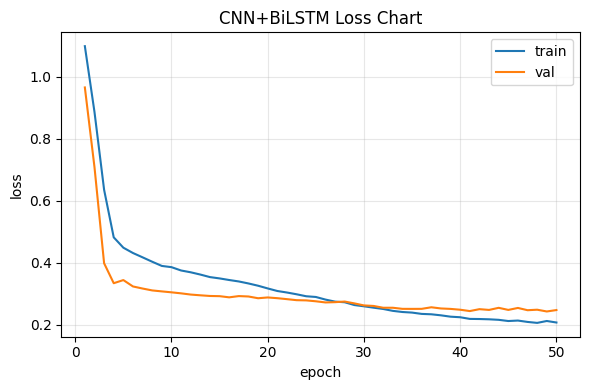

In [37]:
# Plot loss chart
plotLosses(
    trainLosses_CNNBiLSTM, valLosses_CNNBiLSTM,
    title = "CNN+BiLSTM Loss Chart", save_path = config['paths']['results_dir'] + 'CNNBiLSTM_1Lead_loss.png'
)

In [38]:
pd.DataFrame(evalPaperMetrics(model_CNNBiLSTM, testLoader_1Lead, fs = 500, tolerance = 150, device = 'cuda'))

,P_on,P_off,QRS_on,QRS_off,T_on,T_off
m,-0.056070,3.219893,0.036842,1.107895,1.663489,8.265491
σ,7.160708,13.221804,3.077857,5.696931,10.266386,18.575473
Se,0.995148,0.995148,1.000000,1.000000,0.999048,0.999048
PPV,0.792504,0.792504,0.963652,0.963652,0.673299,0.673299
F1,0.882340,0.882340,0.981489,0.981489,0.804448,0.804448


In [39]:
# Grab the signal
sig = recordDf[(recordDf['record_number'] == 181) & (recordDf['channel'] == 'ii')]['signal'].iat[0][500:4500]

# to tensor [B=1, C=1, T]
xb = torch.as_tensor(sig, dtype = torch.float32, device = device).unsqueeze(0).unsqueeze(0)

# run model -> logits [1, 4, L] -> preds [L]
model_CNNBiLSTM.eval()
with torch.no_grad():
    logits = model_CNNBiLSTM(xb)
preds = logits.argmax(1).squeeze(0)  # tensor of class ids per timestep

In [40]:
# Ensure 2D
if preds.dim() == 1:  # (T,) -> (1, T)
    preds = preds.unsqueeze(0)

C, T = preds.shape
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)  # pad along time
predsPadded.shape

torch.Size([1, 5000])

token-acc: 0.926


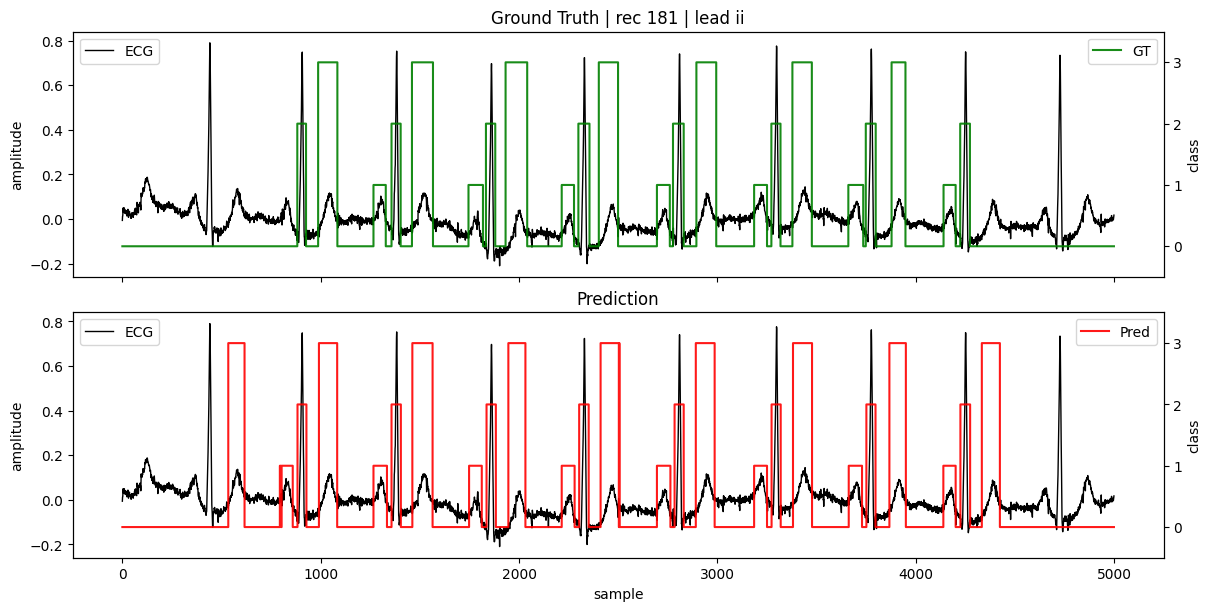

(0.925599992275238, './results/CNNBiLSTM_Patient_181_Lead_II_split.png')

In [41]:
plotPredsVsGt(predsPadded[0], recordDf, 181, 'ii', config, modelName = "CNNBiLSTM")

In [42]:
# Grab the signal
sig = recordDf[(recordDf['record_number'] == 191) & (recordDf['channel'] == 'ii')]['signal'].iat[0][500:4500]

# to tensor [B=1, C=1, T]
xb = torch.as_tensor(sig, dtype = torch.float32, device = device).unsqueeze(0).unsqueeze(0)

# run model -> logits [1, 4, L] -> preds [L]
model_CNNBiLSTM.eval()
with torch.no_grad():
    logits = model_CNNBiLSTM(xb)
preds = logits.argmax(1).squeeze(0)  # tensor of class ids per timestep

In [43]:
# Ensure 2D
if preds.dim() == 1:  # (T,) -> (1, T)
    preds = preds.unsqueeze(0)

C, T = preds.shape
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)  # pad along time
predsPadded.shape

torch.Size([1, 5000])

token-acc: 0.947


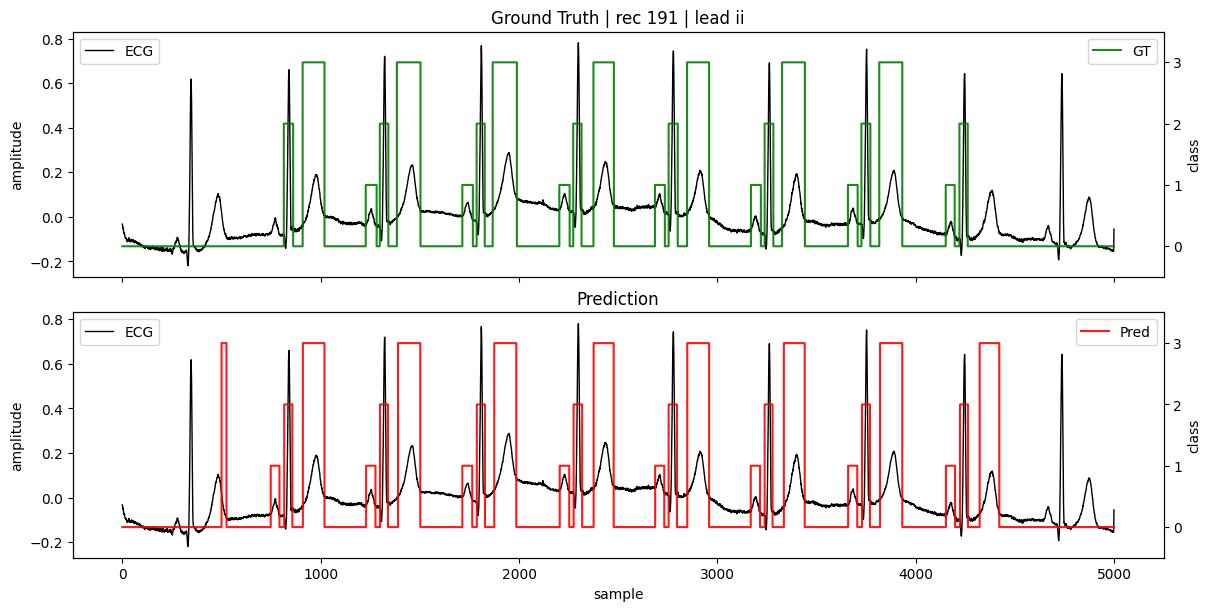

(0.9465999603271484, './results/CNNBiLSTM_Patient_191_Lead_II_split.png')

In [44]:
plotPredsVsGt(predsPadded[0], recordDf, 191, 'ii', config, modelName = "CNNBiLSTM")

### On CNN + BiLSTM (Multi-Leads data) -- Train/Val/Test - 160/20/20

In [45]:
# Model
torch.manual_seed(SEED)  # re-seed right before model init
multiLead_model_CNNBiLSTM = CNNBiLSTM_Model_Profile11(input_channels = 12, num_classes = 4, lstm_hidden = 128, lstm_layers = 1).to(device)

# Number of Parameters
numParams = sum(p.numel() for p in multiLead_model_CNNBiLSTM.parameters())
print(f"Number of total parameters for CNN+BiLSTM Model: {numParams}")

# Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(multiLead_model_CNNBiLSTM.parameters(), lr = 0.0001)

# Train
trainLosses_multiLead_CNNBiLSTM, valLosses_multiLead_CNNBiLSTM = [], []
bestVal, bestEp, bestState = float("inf"), 0, None
epochs = 50
for ep in range(1, epochs + 1):
    trainLoss, trainAcc = runEpoch_MultiLead(multiLead_model_CNNBiLSTM, trainLoader_12Leads, criterion, optimizer, 'cuda')
    valLoss, valAcc = runEpoch_MultiLead(multiLead_model_CNNBiLSTM, valLoader_12Leads, criterion, None, 'cuda')

    trainLosses_multiLead_CNNBiLSTM.append(trainLoss)
    valLosses_multiLead_CNNBiLSTM.append(valLoss)

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d} | train {trainLoss:.4f}/{trainAcc:.3f} | "f"val {valLoss:.4f}/{valAcc:.3f}")

    # keep best by val loss
    if valLoss < bestVal - 1e-4:
        bestVal, bestEp = valLoss, ep
        bestState = {k: v.detach().cpu() for k, v in multiLead_model_CNNBiLSTM.state_dict().items()}

# Load best & Test
if bestState is not None:
    multiLead_model_CNNBiLSTM.load_state_dict(bestState)
    saveBestModel(bestState, config['paths']['checkpoints_dir'] + "CNNBiLSTM_best.pt", epoch = bestEp, val_loss = bestVal)

testLoss, testAcc = runEpoch_MultiLead(multiLead_model_CNNBiLSTM, testLoader_12Leads, criterion, None, 'cuda')
print(f"BEST @ epoch {bestEp} | val_loss = {bestVal:.4f}")
print(f"TEST | loss {testLoss:.4f} | acc {testAcc:.3f}")

Number of total parameters for CNN+BiLSTM Model: 1195208
Epoch 01 | train 1.3757/0.337 | val 1.3496/0.583
Epoch 05 | train 1.0595/0.620 | val 1.0520/0.625
Epoch 10 | train 0.9762/0.635 | val 0.9467/0.650
Epoch 15 | train 0.8388/0.689 | val 0.8041/0.710
Epoch 20 | train 0.6451/0.779 | val 0.5888/0.794
Epoch 25 | train 0.4216/0.835 | val 0.3523/0.866
Epoch 30 | train 0.3783/0.849 | val 0.3142/0.879
Epoch 35 | train 0.3501/0.862 | val 0.3006/0.885
Epoch 40 | train 0.3359/0.867 | val 0.2857/0.886
Epoch 45 | train 0.3791/0.849 | val 0.3909/0.843
Epoch 50 | train 0.3152/0.875 | val 0.2648/0.896
BEST @ epoch 49 | val_loss = 0.2636
TEST | loss 0.2641 | acc 0.899


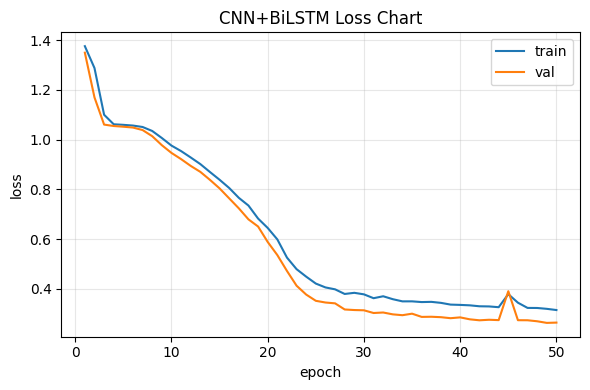

In [46]:
plotLosses(
    trainLosses_multiLead_CNNBiLSTM, valLosses_multiLead_CNNBiLSTM,
    title = "CNN+BiLSTM Loss Chart", save_path = config['paths']['results_dir'] + 'CNNBiLSTM_12Leads_loss.png'
)

In [47]:
pd.DataFrame(evalPaperMetrics(multiLead_model_CNNBiLSTM, testLoader_12Leads, fs = 500, tolerance = 150, device = 'cuda'))

,P_on,P_off,QRS_on,QRS_off,T_on,T_off
m,-0.515288,2.230576,0.207018,0.375000,0.755725,2.102099
σ,8.369544,7.939304,3.905141,5.897754,11.715638,9.940139
Se,0.967977,0.967977,1.000000,1.000000,0.998095,0.998095
PPV,0.909298,0.909298,0.992599,0.992599,0.916484,0.916484
F1,0.937720,0.937720,0.996286,0.996286,0.955550,0.955550


In [48]:
recordNumber = 181

# Pull all rows for this record_number, sort by lead_index.
rec = recordDf[recordDf['record_number'] == recordNumber]
rec = rec.sort_values('lead_index' if 'lead_index' in rec.columns else 'channel')
assert not rec.empty, f"No rows for record_number = {recordNumber}"

# Stack to [C, T]
signals = [np.asarray(s, dtype = np.float32) for s in rec['signal'].tolist()]
tRef = len(signals[0])
assert all(len(s) == tRef for s in signals), "Inconsistent lead lengths across channels."

# Remove first and last 1 second (assumes ~10 s total → cut = T//10)
cut = tRef // 10
lo, hi = cut, tRef - cut
# [C, T'] with 1–9 s kept
signals = [s[lo:hi] for s in signals]

# [C, T']
X = np.stack(signals, axis = 0)
# [1, C, T']
xb = torch.from_numpy(X).to(device = device, dtype = torch.float32).unsqueeze(0)

# Run model
multiLead_model_CNNBiLSTM.eval()
with torch.no_grad():
    # [1, K, T']
    logits = multiLead_model_CNNBiLSTM(xb)

# Per-lead vs fused handling
if logits.dim() == 4:
    # logits: [B, C, K, T′]  -> preds: [C, T′]
    preds = logits.argmax(2).squeeze(0)
else:
    # logits: [B, K, T′]     -> preds: [T′]
    preds = logits.argmax(dim = 1).squeeze(0)

In [49]:
C = preds.size(0)
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)
predsPadded.shape

torch.Size([12, 5000])

token-acc: 0.919


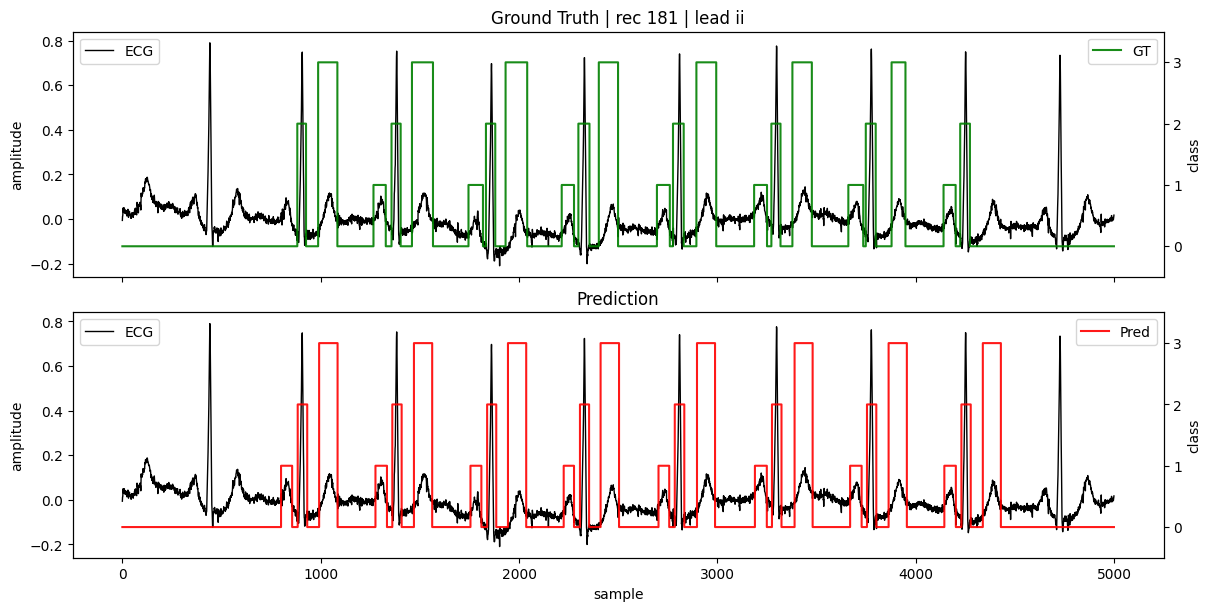

(0.9193999767303467,
 './results/CNNBiLSTM_Multi_Lead_Patient_181_Lead_II_split.png')

In [50]:
plotPredsVsGt(predsPadded[1], recordDf, 181, 'ii', config, modelName = "CNNBiLSTM_Multi_Lead")

In [51]:
recordNumber = 191

# Pull all rows for this record_number, sort by lead_index.
rec = recordDf[recordDf['record_number'] == recordNumber]
rec = rec.sort_values('lead_index' if 'lead_index' in rec.columns else 'channel')
assert not rec.empty, f"No rows for record_number = {recordNumber}"

# Stack to [C, T]
signals = [np.asarray(s, dtype = np.float32) for s in rec['signal'].tolist()]
tRef = len(signals[0])
assert all(len(s) == tRef for s in signals), "Inconsistent lead lengths across channels."

# Remove first and last 1 second (assumes ~10 s total → cut = T//10)
cut = tRef // 10
lo, hi = cut, tRef - cut
# [C, T'] with 1–9 s kept
signals = [s[lo:hi] for s in signals]

# [C, T']
X = np.stack(signals, axis = 0)
# [1, C, T']
xb = torch.from_numpy(X).to(device = device, dtype = torch.float32).unsqueeze(0)

# Run model
multiLead_model_CNNBiLSTM.eval()
with torch.no_grad():
    # [1, K, T']
    logits = multiLead_model_CNNBiLSTM(xb)

# Per-lead vs fused handling
if logits.dim() == 4:
    # logits: [B, C, K, T′]  -> preds: [C, T′]
    preds = logits.argmax(2).squeeze(0)
else:
    # logits: [B, K, T′]     -> preds: [T′]
    preds = logits.argmax(dim = 1).squeeze(0)

In [52]:
C = preds.size(0)
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)
predsPadded.shape

torch.Size([12, 5000])

token-acc: 0.925


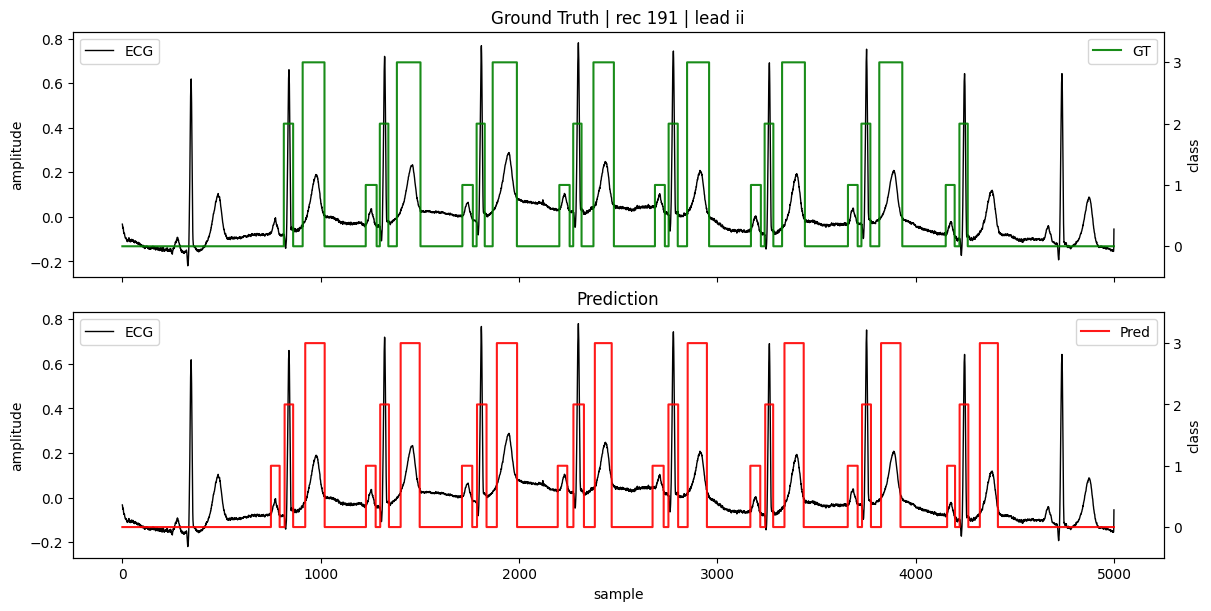

(0.9246000051498413,
 './results/CNNBiLSTM_Multi_Lead_Patient_191_Lead_II_split.png')

In [53]:
plotPredsVsGt(predsPadded[1], recordDf, 191, 'ii', config, modelName = "CNNBiLSTM_Multi_Lead")

### On Criss-Cross Transformer -- Train/Val/Test - 160/20/20

In [54]:
# Model/Loss/Optimizer
torch.manual_seed(SEED)  # re-seed right before model init
model_CCT = CC_Transformer(
    numLeads = 12, numClasses = 4, embedDim = 256,
    depth = 6, numHeads = 8, patchSize = 40, dropout = 0.2
).to(device)

numParams = sum(p.numel() for p in model_CCT.parameters())
print(f"Number of total parameters for CCT Model: {numParams}")

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_CCT.parameters(), lr = 0.0001, weight_decay = 1e-2)

# Train
trainLosses_CCT, valLosses_CCT = [], []
bestVal, bestEp, bestState = float("inf"), 0, None
epochs = 50
for ep in range(1, epochs + 1):
    trainLoss, trainAcc = runEpoch_MultiLead(model_CCT, trainLoader_12Leads, criterion, optimizer, 'cuda')
    valLoss, valAcc = runEpoch_MultiLead(model_CCT, valLoader_12Leads, criterion, None, 'cuda')

    trainLosses_CCT.append(trainLoss)
    valLosses_CCT.append(valLoss)

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d} | train {trainLoss:.4f}/{trainAcc:.3f} | val {valLoss:.4f}/{valAcc:.3f}")

    # keep best by val loss
    if valLoss < bestVal - 1e-4:
        bestVal, bestEp = valLoss, ep
        bestState = {k: v.detach().cpu() for k, v in model_CCT.state_dict().items()}

# Load best & Save
if bestState is not None:
    model_CCT.load_state_dict(bestState)
    saveBestModel(bestState, config['paths']['checkpoints_dir'] + "CCT_best.pt", epoch = bestEp, val_loss = bestVal)

# Test
testLoss, testAcc = runEpoch_MultiLead(model_CCT, testLoader_12Leads, criterion, None, 'cuda')
print(f"BEST @ epoch {bestEp} | val_loss = {bestVal:.4f}")
print(f"TEST | loss {testLoss:.4f} | acc {testAcc:.3f}")

Number of total parameters for CCT Model: 7236100
Epoch 01 | train 0.9629/0.657 | val 0.7022/0.766
Epoch 05 | train 0.6241/0.769 | val 0.5679/0.791
Epoch 10 | train 0.5040/0.809 | val 0.4660/0.827
Epoch 15 | train 0.3964/0.845 | val 0.3609/0.859
Epoch 20 | train 0.3417/0.865 | val 0.3295/0.873
Epoch 25 | train 0.3054/0.878 | val 0.3225/0.880
Epoch 30 | train 0.2875/0.885 | val 0.3224/0.882
Epoch 35 | train 0.2723/0.892 | val 0.3174/0.887
Epoch 40 | train 0.2527/0.898 | val 0.3327/0.884
Epoch 45 | train 0.2494/0.900 | val 0.3334/0.888
Epoch 50 | train 0.2486/0.900 | val 0.3190/0.891
BEST @ epoch 41 | val_loss = 0.3072
TEST | loss 0.2947 | acc 0.890


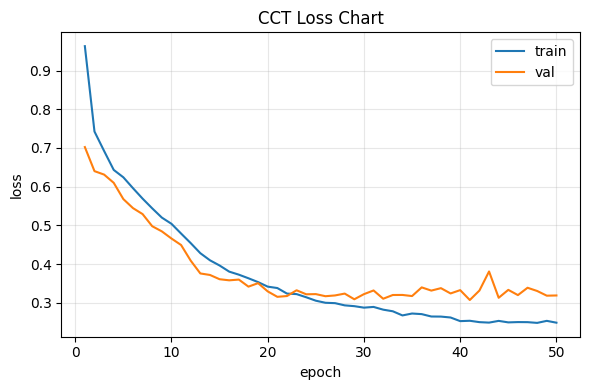

In [55]:
# Plot loss chart
plotLosses(
    trainLosses_CCT, valLosses_CCT,
    title = "CCT Loss Chart", save_path = config['paths']['results_dir'] + 'CCT_loss.png'
)

In [56]:
pd.DataFrame(evalPaperMetrics(model_CCT, testLoader_12Leads, fs = 500, tolerance = 150, device = 'cuda'))

,P_on,P_off,QRS_on,QRS_off,T_on,T_off
m,-3.097961,-1.657418,-0.371053,1.215789,-0.329912,4.994616
σ,10.678724,9.367958,5.749298,6.332104,14.298629,11.744859
Se,0.856866,0.856866,1.000000,1.000000,0.974286,0.972857
PPV,0.910779,0.910779,0.993464,0.993464,0.963277,0.961864
F1,0.883000,0.883000,0.996721,0.996721,0.968750,0.967330


In [57]:
recordNumber = 181

# Pull all rows for this record_number, sort by lead_index.
rec = recordDf[recordDf['record_number'] == recordNumber]
rec = rec.sort_values('lead_index' if 'lead_index' in rec.columns else 'channel')
assert not rec.empty, f"No rows for record_number = {recordNumber}"

# Stack to [C, T]
signals = [np.asarray(s, dtype = np.float32) for s in rec['signal'].tolist()]
tRef = len(signals[0])
assert all(len(s) == tRef for s in signals), "Inconsistent lead lengths across channels."

# Remove first and last 1 second (assumes ~10 s total → cut = T//10)
cut = tRef // 10
lo, hi = cut, tRef - cut
# [C, T'] with 1–9 s kept
signals = [s[lo:hi] for s in signals]

# [C, T']
X = np.stack(signals, axis = 0)
# [1, C, T']
xb = torch.from_numpy(X).to(device = device, dtype = torch.float32).unsqueeze(0)

# Run model
model_CCT.eval()
with torch.no_grad():
    # [1, K, T']
    logits = model_CCT(xb)

# Per-lead vs fused handling
if logits.dim() == 4:
    # logits: [B, C, K, T′]  -> preds: [C, T′]
    preds = logits.argmax(2).squeeze(0)
else:
    # logits: [B, K, T′]     -> preds: [T′]
    preds = logits.argmax(dim = 1).squeeze(0)

In [58]:
C = preds.size(0)
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)
predsPadded.shape

torch.Size([12, 5000])

token-acc: 0.948


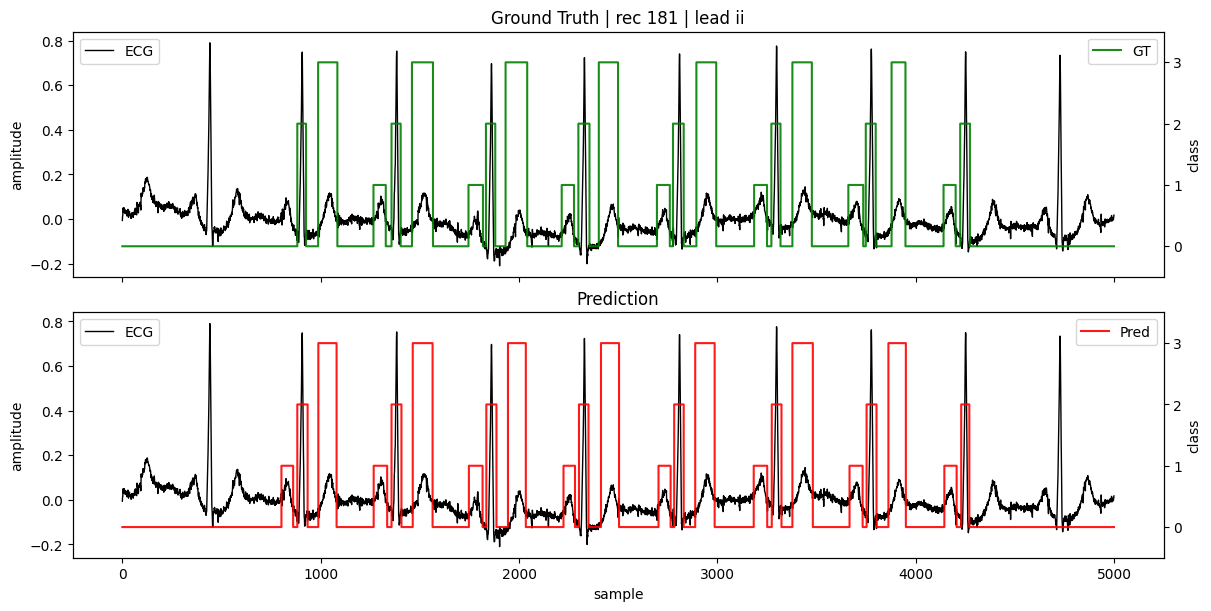

(0.9483999609947205, './results/CCT_Patient_181_Lead_II_split.png')

In [59]:
plotPredsVsGt(predsPadded[1], recordDf, 181, 'ii', config, modelName = "CCT")

In [60]:
recordNumber = 191

# Pull all rows for this record_number, sort by lead_index.
rec = recordDf[recordDf['record_number'] == recordNumber]
rec = rec.sort_values('lead_index' if 'lead_index' in rec.columns else 'channel')
assert not rec.empty, f"No rows for record_number = {recordNumber}"

# Stack to [C, T]
signals = [np.asarray(s, dtype = np.float32) for s in rec['signal'].tolist()]
tRef = len(signals[0])
assert all(len(s) == tRef for s in signals), "Inconsistent lead lengths across channels."

# Remove first and last 1 second (assumes ~10 s total → cut = T//10)
cut = tRef // 10
lo, hi = cut, tRef - cut
# [C, T'] with 1–9 s kept
signals = [s[lo:hi] for s in signals]

# [C, T']
X = np.stack(signals, axis = 0)
# [1, C, T']
xb = torch.from_numpy(X).to(device = device, dtype = torch.float32).unsqueeze(0)

# Run model
model_CCT.eval()
with torch.no_grad():
    # [1, K, T']
    logits = model_CCT(xb)

# Per-lead vs fused handling
if logits.dim() == 4:
    # logits: [B, C, K, T′]  -> preds: [C, T′]
    preds = logits.argmax(2).squeeze(0)
else:
    # logits: [B, K, T′]     -> preds: [T′]
    preds = logits.argmax(dim = 1).squeeze(0)

In [61]:
C = preds.size(0)
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)
predsPadded.shape

torch.Size([12, 5000])

token-acc: 0.952


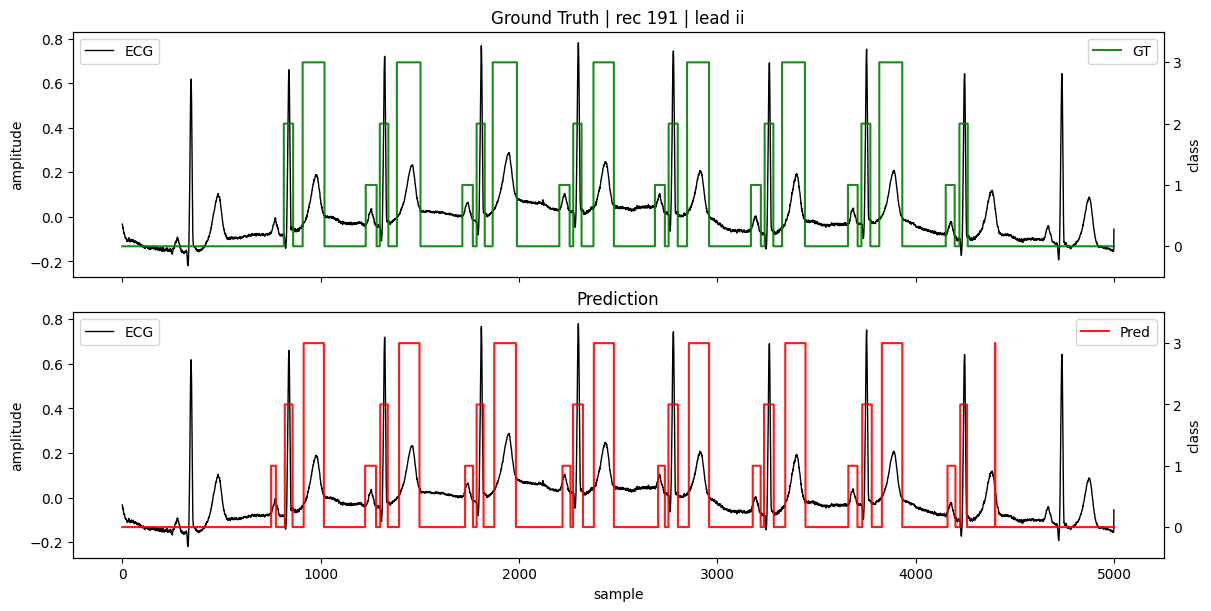

(0.9515999555587769, './results/CCT_Patient_191_Lead_II_split.png')

In [62]:
plotPredsVsGt(predsPadded[1], recordDf, 191, 'ii', config, modelName = "CCT")

#### Sorted On Channels instead of Lead Index

In [63]:
pd.DataFrame(evalPaperMetrics(model_CCT, testLoader_12Leads_sortedOn_Channels, fs = 500, tolerance = 150, device = 'cuda'))

,P_on,P_off,QRS_on,QRS_off,T_on,T_off
m,-11.951613,7.360215,-0.336404,1.270614,-0.624749,9.376387
σ,16.487787,10.766926,7.003225,7.890257,14.441263,16.455781
Se,0.360990,0.360990,1.000000,1.000000,0.950476,0.943810
PPV,0.837838,0.837838,0.994764,0.994764,0.950476,0.943810
F1,0.504578,0.504578,0.997375,0.997375,0.950476,0.943810


In [64]:
recordNumber = 191

# Pull all rows for this record_number, sort by lead_index.
rec = recordDf[recordDf['record_number'] == recordNumber]
rec = rec.sort_values('channel' if 'channel' in rec.columns else 'lead_index')
assert not rec.empty, f"No rows for record_number = {recordNumber}"

# Stack to [C, T]
signals = [np.asarray(s, dtype = np.float32) for s in rec['signal'].tolist()]
tRef = len(signals[0])
assert all(len(s) == tRef for s in signals), "Inconsistent lead lengths across channels."

# Remove first and last 1 second (assumes ~10 s total → cut = T//10)
cut = tRef // 10
lo, hi = cut, tRef - cut
# [C, T'] with 1–9 s kept
signals = [s[lo:hi] for s in signals]

# [C, T']
X = np.stack(signals, axis = 0)
# [1, C, T']
xb = torch.from_numpy(X).to(device = device, dtype = torch.float32).unsqueeze(0)

# Run model
model_CCT.eval()
with torch.no_grad():
    # [1, K, T']
    logits = model_CCT(xb)

# Per-lead vs fused handling
if logits.dim() == 4:
    # logits: [B, C, K, T′]  -> preds: [C, T′]
    preds = logits.argmax(2).squeeze(0)
else:
    # logits: [B, K, T′]     -> preds: [T′]
    preds = logits.argmax(dim = 1).squeeze(0)

In [65]:
C = preds.size(0)
zerosL = preds.new_zeros(C, 500)
zerosR = preds.new_zeros(C, 500)
predsPadded = torch.cat([zerosL, preds, zerosR], dim = 1)
predsPadded.shape

torch.Size([12, 5000])

token-acc: 0.871


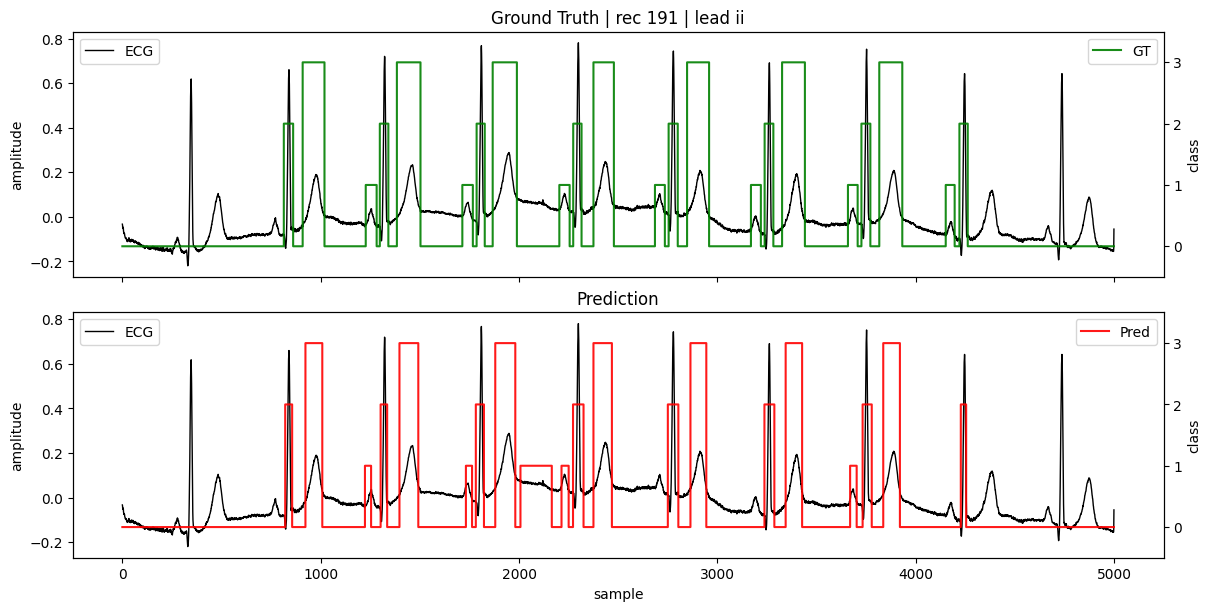

(0.8707999587059021, './results/CCT_Patient_191_Lead_II_split.png')

In [66]:
# Now, Lead 'ii' -> 4 index
plotPredsVsGt(predsPadded[4], recordDf, 191, 'ii', config, modelName = "CCT")

## Full Training (All 5 Models) - 10 K-Fold Validation

### On U-Net

[Fold 1/10] Ep 01 | train 1.3507 | val 1.3199
[Fold 1/10] Ep 10 | train 0.7041 | val 0.7768
[Fold 1/10] Ep 20 | train 0.2095 | val 0.3587
[Fold 1/10] Ep 30 | train 0.1283 | val 0.3442
[Fold 1/10] Ep 40 | train 0.1025 | val 0.3925
[Fold 1/10] Ep 50 | train 0.0896 | val 0.4221
[Fold 2/10] Ep 01 | train 1.3456 | val 1.3123
[Fold 2/10] Ep 10 | train 0.6596 | val 0.7725
[Fold 2/10] Ep 20 | train 0.2106 | val 0.3741
[Fold 2/10] Ep 30 | train 0.1271 | val 0.3638
[Fold 2/10] Ep 40 | train 0.1030 | val 0.4007
[Fold 2/10] Ep 50 | train 0.0903 | val 0.4385
[Fold 3/10] Ep 01 | train 1.3500 | val 1.2752
[Fold 3/10] Ep 10 | train 0.6661 | val 0.7078
[Fold 3/10] Ep 20 | train 0.2100 | val 0.3254
[Fold 3/10] Ep 30 | train 0.1276 | val 0.3079
[Fold 3/10] Ep 40 | train 0.1022 | val 0.3270
[Fold 3/10] Ep 50 | train 0.0870 | val 0.3588
[Fold 4/10] Ep 01 | train 1.3515 | val 1.2831
[Fold 4/10] Ep 10 | train 0.6777 | val 0.7300
[Fold 4/10] Ep 20 | train 0.2074 | val 0.3814
[Fold 4/10] Ep 30 | train 0.1249 |

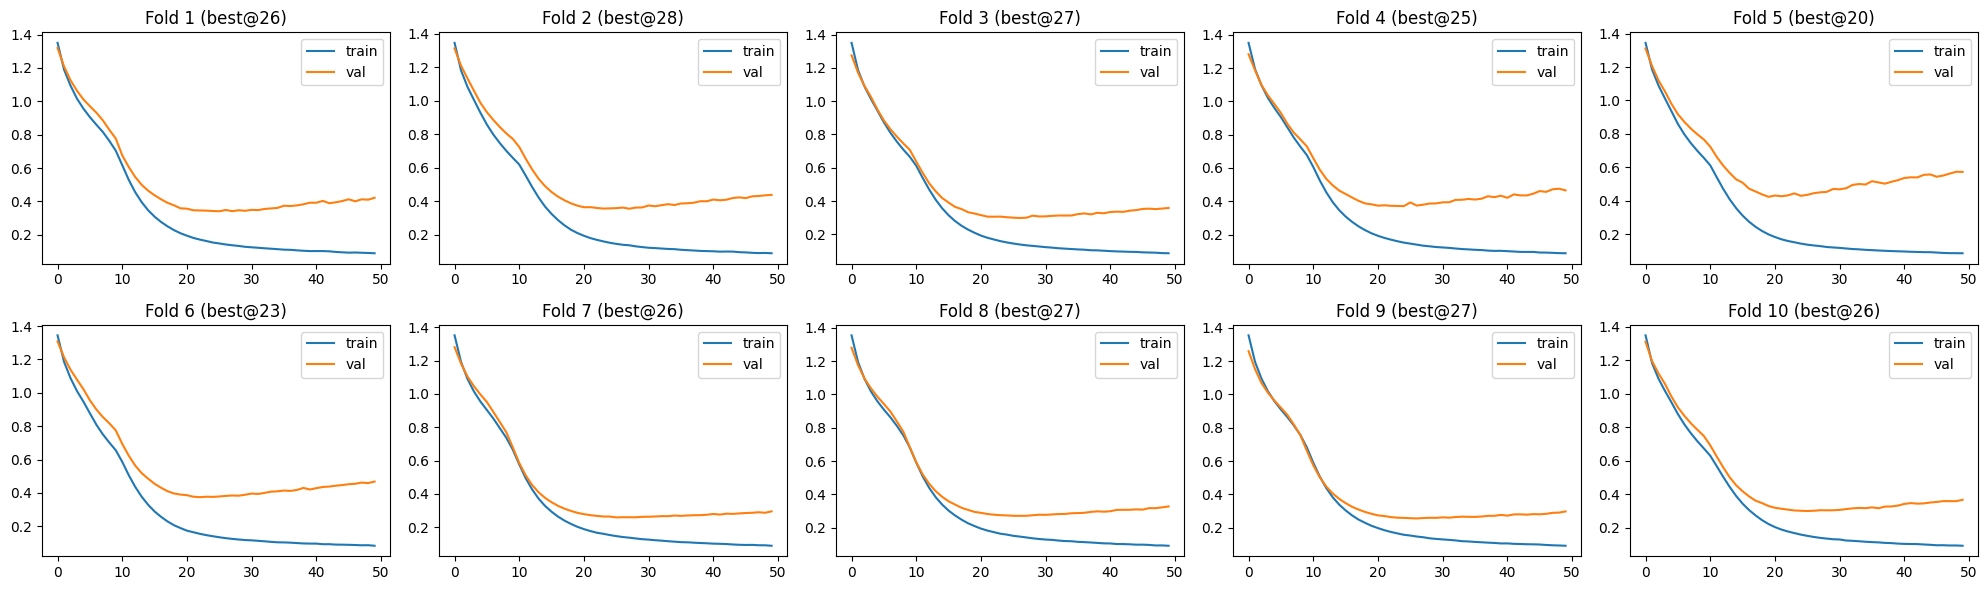


F1 by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.8946 0.8946  0.9866   0.9866 0.9011 0.9011
   2 0.8053 0.8053  0.9814   0.9814 0.8774 0.8760
   3 0.8145 0.8145  0.9592   0.9562 0.8733 0.8733
   4 0.9073 0.9073  0.9736   0.9736 0.8933 0.8906
   5 0.7974 0.7974  0.9673   0.9673 0.8543 0.8515
   6 0.7193 0.7210  0.9511   0.9511 0.8741 0.8737
   7 0.8721 0.8737  0.9711   0.9711 0.8785 0.8703
   8 0.9266 0.9266  0.9917   0.9917 0.9256 0.9256
   9 0.9018 0.9018  0.9878   0.9878 0.9146 0.9156
  10 0.9358 0.9358  0.9930   0.9930 0.9388 0.9388
Mean 0.8575 0.8578  0.9763   0.9760 0.8931 0.8917

Precision (PPV) by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.8151 0.8151  0.9759   0.9759 0.8207 0.8207
   2 0.6794 0.6794  0.9696   0.9696 0.8060 0.8047
   3 0.6887 0.6887  0.9325   0.9295 0.7808 0.7808
   4 0.8348 0.8348  0.9589   0.9589 0.8132 0.8107
   5 0.6674 0.6674  0.9655   0.9655 0.7593 0.7568
   6 0.5833 0.5846  0.9250   0.9250 0.8120 0.81

In [67]:
model = lambda: UNet1D(input_channels = 1, num_classes = 4).to(device)

Summary = trainKFoldGeneric(
    FoldIter = makeKFoldPatientTensors(recordDf, 500, k = 10, valFrac = 0.1),
    ModelFn = model,
    RunEpochFn = runEpoch,
    seed = SEED,
    Device = device, Epochs = 50, BatchSize = 8, Lr = 0.0001, Criterion = torch.nn.CrossEntropyLoss(), optimName = 'Adam',
    EvalFn = evalPaperMetrics,
    EvalKwargs = {'fs': 500, 'tolerance': 150, 'device': device},
    SaveFigPath = config["paths"]["results_dir"] + f"U-Net_Single_Lead_10KFold.png",
    SaveResultsPath = config["paths"]["results_dir"] + f"U-Net_Single_Lead_10KFold"
)

### On U-Net (Multi Lead)

[Fold 1/10] Ep 01 | train 1.4809 | val 1.4423
[Fold 1/10] Ep 10 | train 1.3598 | val 1.3658
[Fold 1/10] Ep 20 | train 1.2900 | val 1.2967
[Fold 1/10] Ep 30 | train 1.2299 | val 1.2442
[Fold 1/10] Ep 40 | train 1.1713 | val 1.1905
[Fold 1/10] Ep 50 | train 1.1107 | val 1.1395
[Fold 2/10] Ep 01 | train 1.4804 | val 1.4386
[Fold 2/10] Ep 10 | train 1.3605 | val 1.3594
[Fold 2/10] Ep 20 | train 1.2904 | val 1.2932
[Fold 2/10] Ep 30 | train 1.2291 | val 1.2337
[Fold 2/10] Ep 40 | train 1.1693 | val 1.1791
[Fold 2/10] Ep 50 | train 1.1115 | val 1.1268
[Fold 3/10] Ep 01 | train 1.4800 | val 1.4412
[Fold 3/10] Ep 10 | train 1.3609 | val 1.3649
[Fold 3/10] Ep 20 | train 1.2905 | val 1.2989
[Fold 3/10] Ep 30 | train 1.2306 | val 1.2467
[Fold 3/10] Ep 40 | train 1.1712 | val 1.1939
[Fold 3/10] Ep 50 | train 1.1131 | val 1.1400
[Fold 4/10] Ep 01 | train 1.4795 | val 1.4373
[Fold 4/10] Ep 10 | train 1.3617 | val 1.3626
[Fold 4/10] Ep 20 | train 1.2908 | val 1.2988
[Fold 4/10] Ep 30 | train 1.2310 |

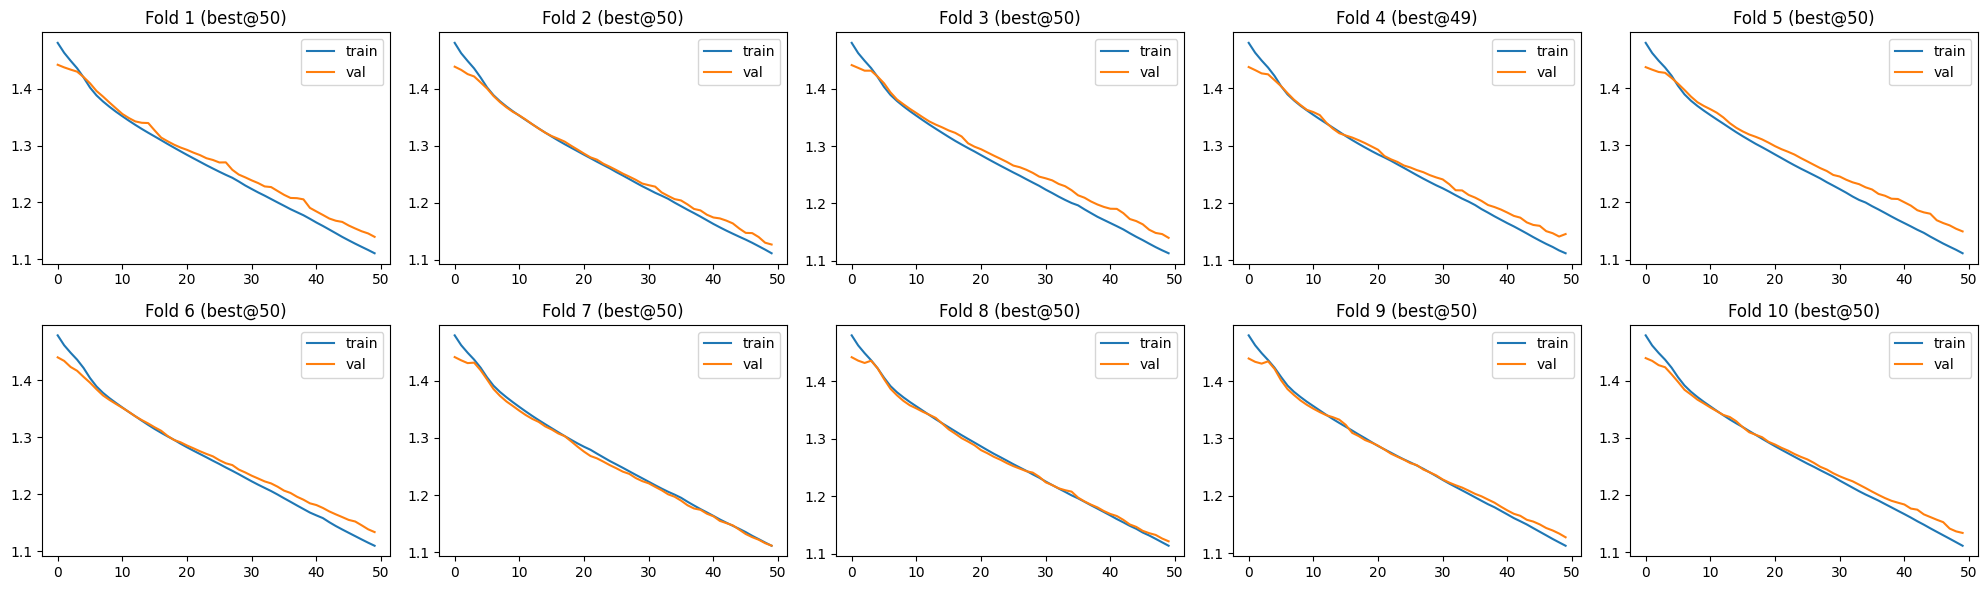


F1 by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.3551 0.4211  0.4309   0.4339 0.4009 0.3420
   2 0.3064 0.3767  0.4234   0.4186 0.3685 0.3291
   3 0.2896 0.3433  0.3809   0.3922 0.3488 0.3173
   4 0.3100 0.3690  0.3718   0.3843 0.3684 0.3410
   5 0.3334 0.3815  0.4056   0.4024 0.3890 0.3442
   6 0.2815 0.3304  0.4169   0.4182 0.3919 0.3468
   7 0.3119 0.3672  0.4325   0.4214 0.3664 0.3271
   8 0.3570 0.4114  0.4276   0.4216 0.4078 0.3615
   9 0.2376 0.2975  0.3756   0.3820 0.4119 0.3730
  10 0.3576 0.4071  0.4578   0.4548 0.4089 0.3612
Mean 0.3140 0.3705  0.4123   0.4129 0.3863 0.3443

Precision (PPV) by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.2535 0.3006  0.2955   0.2976 0.2662 0.2271
   2 0.2086 0.2565  0.2925   0.2891 0.2401 0.2144
   3 0.1914 0.2270  0.2557   0.2633 0.2240 0.2038
   4 0.2139 0.2547  0.2475   0.2559 0.2406 0.2226
   5 0.2263 0.2589  0.2782   0.2759 0.2587 0.2289
   6 0.1842 0.2162  0.2864   0.2874 0.2618 0.23

In [68]:
model = lambda: UNet1D(input_channels = 12, num_classes = 4).to(device)

Summary = trainKFoldGeneric(
    FoldIter = makeKFoldPatientTensors12Leads(recordDf, fs = 500, trimSeconds = 1.0, k = 10, valFrac = 0.10),
    ModelFn = model,
    RunEpochFn = runEpoch_MultiLead,
    seed = SEED,
    Device = device, Epochs = 50, BatchSize = 8, Lr = 0.0001, Criterion = torch.nn.CrossEntropyLoss(), optimName = 'Adam',
    EvalFn = evalPaperMetrics,
    EvalKwargs = {'fs': 500, 'tolerance': 150, 'device': device},
    SaveFigPath = config["paths"]["results_dir"] + f"U-Net_Multi_Lead_10KFold.png",
    SaveResultsPath = config["paths"]["results_dir"] + f"U-Net_Multi_Lead_10KFold"
)

### On CCT (Multi Lead)

[Fold 1/10] Ep 01 | train 0.9793 | val 0.8781
[Fold 1/10] Ep 10 | train 0.4954 | val 0.5406
[Fold 1/10] Ep 20 | train 0.3406 | val 0.4252
[Fold 1/10] Ep 30 | train 0.2887 | val 0.4427
[Fold 1/10] Ep 40 | train 0.2624 | val 0.4199
[Fold 1/10] Ep 50 | train 0.2338 | val 0.4027
[Fold 2/10] Ep 01 | train 0.9735 | val 0.7585
[Fold 2/10] Ep 10 | train 0.4881 | val 0.5226
[Fold 2/10] Ep 20 | train 0.3349 | val 0.4006
[Fold 2/10] Ep 30 | train 0.2871 | val 0.3895
[Fold 2/10] Ep 40 | train 0.2639 | val 0.3627
[Fold 2/10] Ep 50 | train 0.2278 | val 0.3619
[Fold 3/10] Ep 01 | train 0.9536 | val 0.9790
[Fold 3/10] Ep 10 | train 0.4739 | val 0.5187
[Fold 3/10] Ep 20 | train 0.3344 | val 0.4194
[Fold 3/10] Ep 30 | train 0.2884 | val 0.4421
[Fold 3/10] Ep 40 | train 0.2627 | val 0.4116
[Fold 3/10] Ep 50 | train 0.2296 | val 0.4188
[Fold 4/10] Ep 01 | train 0.9548 | val 1.0364
[Fold 4/10] Ep 10 | train 0.4898 | val 0.6011
[Fold 4/10] Ep 20 | train 0.3292 | val 0.4632
[Fold 4/10] Ep 30 | train 0.2840 |

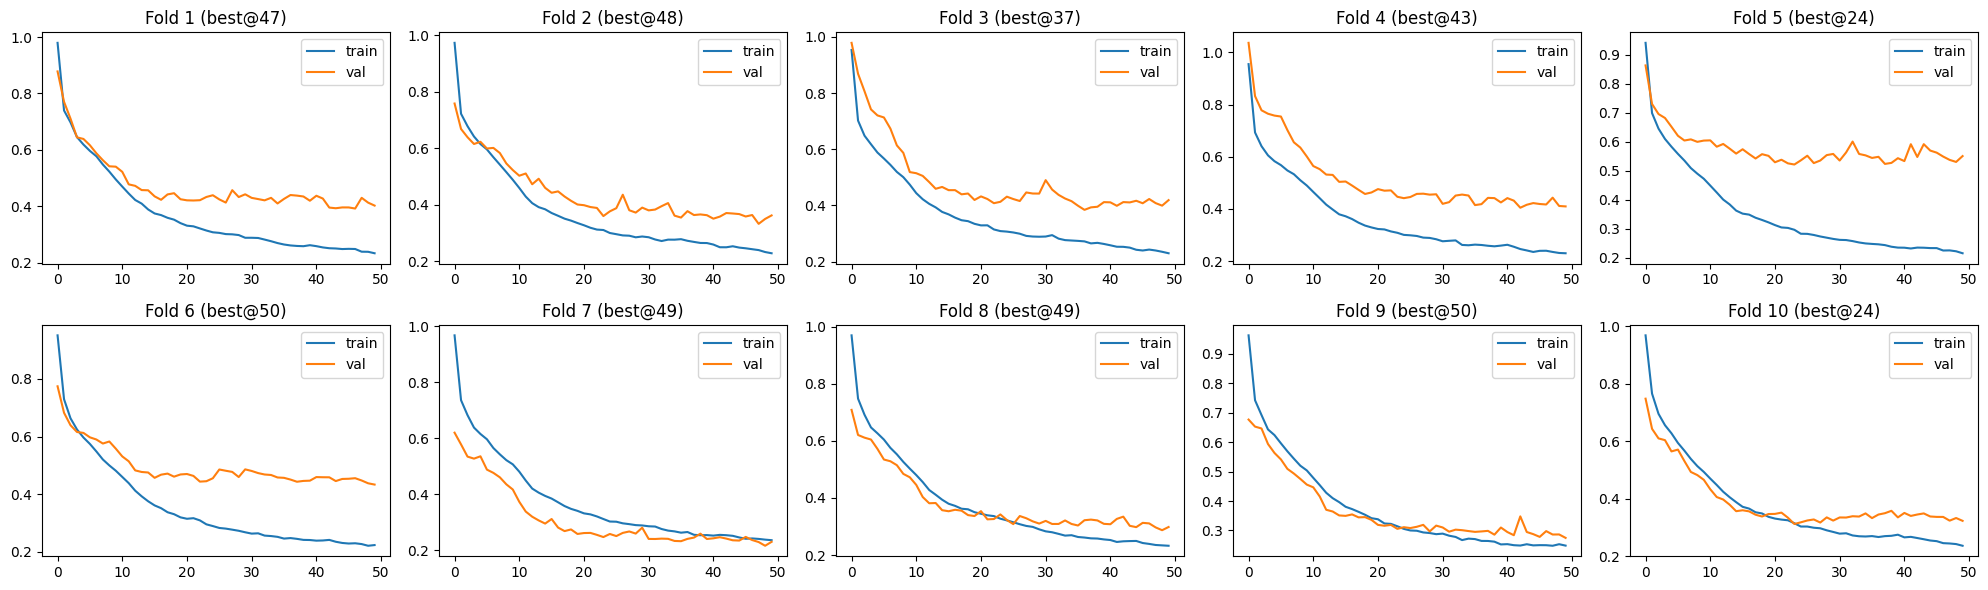


F1 by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.8935 0.8935  0.9934   0.9934 0.9282 0.9271
   2 0.8527 0.8527  0.9943   0.9943 0.8958 0.8973
   3 0.7107 0.7101  0.9785   0.9785 0.9070 0.8989
   4 0.8320 0.8320  0.9689   0.9685 0.8903 0.8865
   5 0.7600 0.7606  0.9904   0.9904 0.8429 0.8514
   6 0.6989 0.6977  0.9872   0.9823 0.8233 0.8209
   7 0.7866 0.7890  0.9836   0.9836 0.8155 0.8231
   8 0.9146 0.9152  0.9942   0.9942 0.9742 0.9742
   9 0.9023 0.9023  0.9969   0.9969 0.9191 0.9155
  10 0.8990 0.8990  0.9974   0.9974 0.9661 0.9661
Mean 0.8250 0.8252  0.9885   0.9879 0.8962 0.8961

Precision (PPV) by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.8529 0.8529  0.9868   0.9868 0.9016 0.9005
   2 0.8053 0.8053  0.9940   0.9940 0.8564 0.8578
   3 0.5885 0.5880  0.9648   0.9648 0.8414 0.8339
   4 0.7916 0.7916  0.9447   0.9442 0.8421 0.8385
   5 0.6830 0.6835  0.9885   0.9885 0.8207 0.8290
   6 0.6013 0.6002  0.9786   0.9738 0.7487 0.74

In [69]:
model = lambda: CC_Transformer(
    numLeads = 12, numClasses = 4, embedDim = 256,
    depth = 6, numHeads = 8, patchSize = 40, dropout = 0.2
).to(device)

Summary = trainKFoldGeneric(
    FoldIter = makeKFoldPatientTensors12Leads(recordDf, fs = 500, trimSeconds = 1.0, k = 10, valFrac = 0.1),
    ModelFn = model,
    RunEpochFn = runEpoch_MultiLead,
    seed = SEED,
    Device = device, Epochs = 50, BatchSize = 8, Lr = 0.0001, Criterion = torch.nn.CrossEntropyLoss(), optimName = 'AdamW',
    EvalFn = evalPaperMetrics,
    EvalKwargs = {'fs': 500, 'tolerance': 150, 'device': device},
    SaveFigPath = config["paths"]["results_dir"] + f"CCT_Multi_Lead_10KFold.png",
    SaveResultsPath = config["paths"]["results_dir"] + f"CCT_Multi_Lead_10KFold"
)

### On CNN + BiLSTM (Multi Lead)

[Fold 1/10] Ep 01 | train 1.3759 | val 1.3503
[Fold 1/10] Ep 10 | train 0.9777 | val 0.9532
[Fold 1/10] Ep 20 | train 0.5912 | val 0.5946
[Fold 1/10] Ep 30 | train 0.3573 | val 0.4125
[Fold 1/10] Ep 40 | train 0.3219 | val 0.3766
[Fold 1/10] Ep 50 | train 0.3210 | val 0.3668
[Fold 2/10] Ep 01 | train 1.3757 | val 1.3472
[Fold 2/10] Ep 10 | train 0.9851 | val 0.9149
[Fold 2/10] Ep 20 | train 0.6286 | val 0.5956
[Fold 2/10] Ep 30 | train 0.3445 | val 0.3794
[Fold 2/10] Ep 40 | train 0.3048 | val 0.3664
[Fold 2/10] Ep 50 | train 0.2811 | val 0.3515
[Fold 3/10] Ep 01 | train 1.3758 | val 1.3518
[Fold 3/10] Ep 10 | train 0.9771 | val 0.9742
[Fold 3/10] Ep 20 | train 0.6094 | val 0.6142
[Fold 3/10] Ep 30 | train 0.3545 | val 0.3627
[Fold 3/10] Ep 40 | train 0.3076 | val 0.3305
[Fold 3/10] Ep 50 | train 0.2848 | val 0.3186
[Fold 4/10] Ep 01 | train 1.3757 | val 1.3528
[Fold 4/10] Ep 10 | train 0.9606 | val 1.0342
[Fold 4/10] Ep 20 | train 0.6476 | val 0.7287
[Fold 4/10] Ep 30 | train 0.3516 |

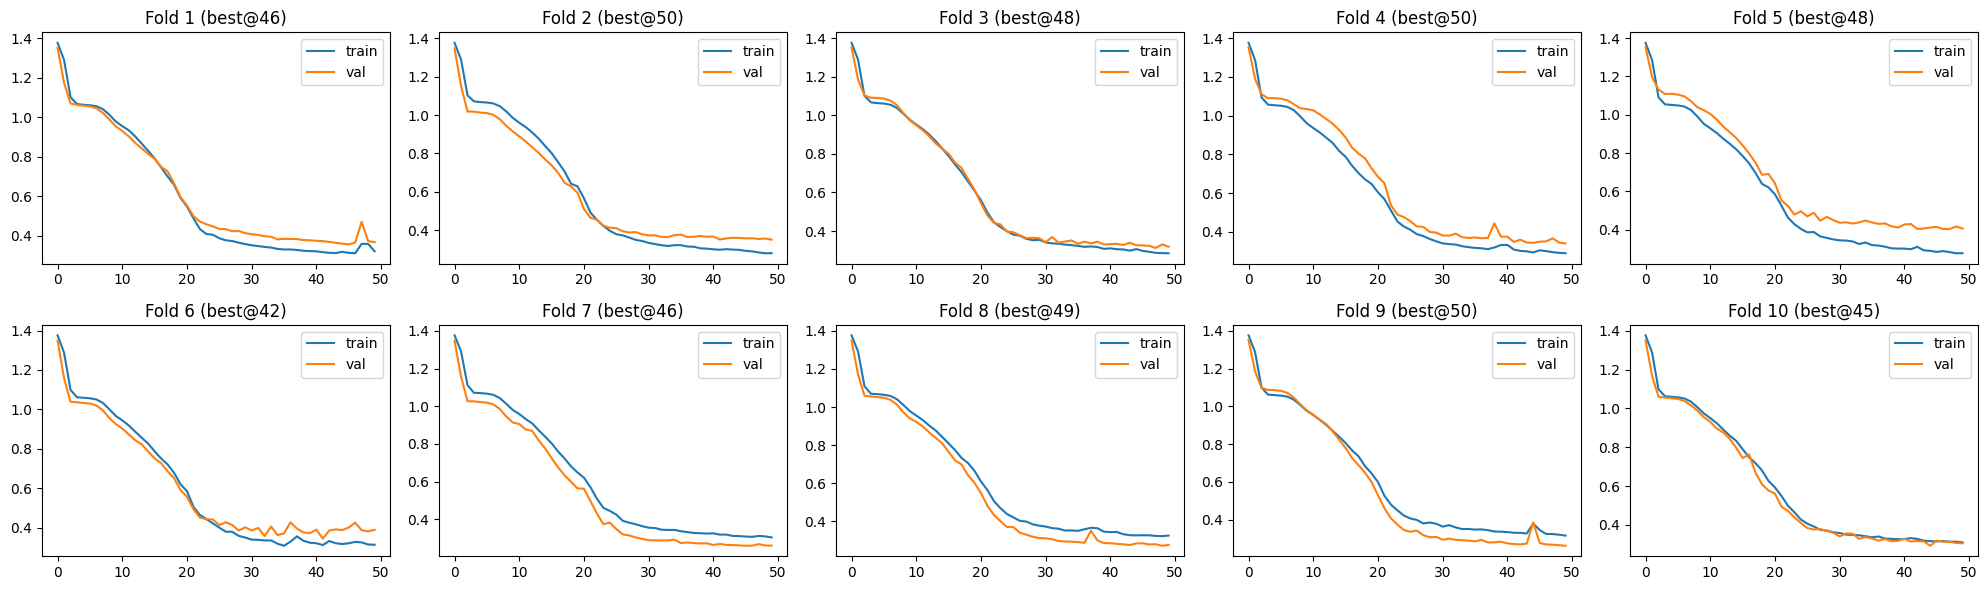


F1 by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.9007 0.9012  0.9936   0.9877 0.9388 0.9372
   2 0.8872 0.8872  0.9790   0.9790 0.9079 0.9041
   3 0.8183 0.8264  0.9561   0.9561 0.9031 0.8972
   4 0.9202 0.9217  0.9883   0.9883 0.9310 0.9236
   5 0.8034 0.8034  0.9921   0.9921 0.9386 0.9395
   6 0.7560 0.7582  0.9930   0.9926 0.9444 0.9252
   7 0.8961 0.8989  0.9836   0.9836 0.9290 0.8878
   8 0.9306 0.9306  0.9913   0.9913 0.9317 0.9317
   9 0.9187 0.9187  0.9969   0.9969 0.9491 0.9491
  10 0.9262 0.9262  0.9974   0.9974 0.9551 0.9551
Mean 0.8757 0.8772  0.9871   0.9865 0.9329 0.9250

Precision (PPV) by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.8299 0.8304  0.9873   0.9815 0.8881 0.8866
   2 0.8024 0.8024  0.9661   0.9661 0.8533 0.8497
   3 0.7111 0.7180  0.9212   0.9212 0.8310 0.8256
   4 0.8585 0.8599  0.9768   0.9768 0.9073 0.9001
   5 0.6872 0.6872  0.9940   0.9940 0.9133 0.9142
   6 0.6161 0.6180  0.9934   0.9930 0.9264 0.90

In [70]:
model = lambda: CNNBiLSTM_Model_Profile11(input_channels = 12, num_classes = 4, lstm_hidden = 128, lstm_layers = 1).to(device)

Summary = trainKFoldGeneric(
    FoldIter = makeKFoldPatientTensors12Leads(recordDf, fs = 500, trimSeconds = 1.0, k = 10, valFrac = 0.10),
    ModelFn = model,
    RunEpochFn = runEpoch_MultiLead,
    seed = SEED,
    Device = device, Epochs = 50, BatchSize = 8, Lr = 0.0001, Criterion = torch.nn.CrossEntropyLoss(), optimName = 'Adam',
    EvalFn = evalPaperMetrics,
    EvalKwargs = {'fs': 500, 'tolerance': 150, 'device': device},
    SaveFigPath = config["paths"]["results_dir"] + f"CNNBiLSTM_Multi_Lead_10KFold.png",
    SaveResultsPath = config["paths"]["results_dir"] + f"CNNBiLSTM_Multi_Lead_10KFold"
)

### On CNN + BiLSTM

[Fold 1/10] Ep 01 | train 1.0969 | val 0.9354
[Fold 1/10] Ep 10 | train 0.3821 | val 0.4668
[Fold 1/10] Ep 20 | train 0.3083 | val 0.3967
[Fold 1/10] Ep 30 | train 0.2411 | val 0.3416
[Fold 1/10] Ep 40 | train 0.2197 | val 0.3405
[Fold 1/10] Ep 50 | train 0.2125 | val 0.3188
[Fold 2/10] Ep 01 | train 1.1024 | val 0.8804
[Fold 2/10] Ep 10 | train 0.3666 | val 0.3917
[Fold 2/10] Ep 20 | train 0.2983 | val 0.3747
[Fold 2/10] Ep 30 | train 0.2378 | val 0.3552
[Fold 2/10] Ep 40 | train 0.2123 | val 0.3926
[Fold 2/10] Ep 50 | train 0.2038 | val 0.3836
[Fold 3/10] Ep 01 | train 1.1001 | val 1.0007
[Fold 3/10] Ep 10 | train 0.3661 | val 0.4105
[Fold 3/10] Ep 20 | train 0.2804 | val 0.3527
[Fold 3/10] Ep 30 | train 0.2334 | val 0.2956
[Fold 3/10] Ep 40 | train 0.2228 | val 0.2930
[Fold 3/10] Ep 50 | train 0.1967 | val 0.2935
[Fold 4/10] Ep 01 | train 1.0899 | val 1.0269
[Fold 4/10] Ep 10 | train 0.3509 | val 0.4422
[Fold 4/10] Ep 20 | train 0.2905 | val 0.3913
[Fold 4/10] Ep 30 | train 0.2416 |

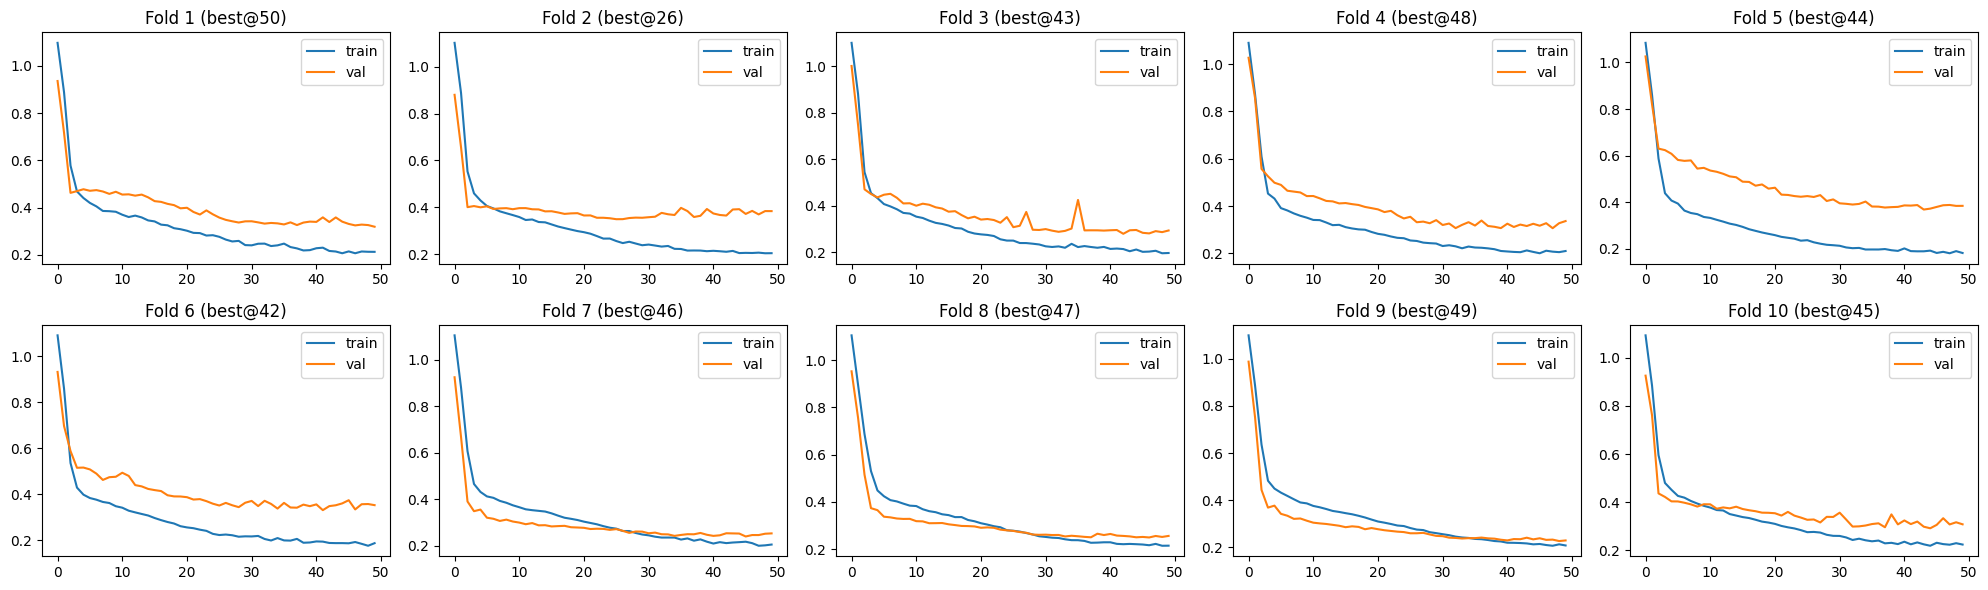


F1 by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.8566 0.8566  0.9491   0.9491 0.8746 0.8746
   2 0.7843 0.7853  0.9655   0.9655 0.8234 0.8160
   3 0.7736 0.7747  0.9289   0.9264 0.8193 0.8168
   4 0.8593 0.8593  0.9561   0.9543 0.8426 0.8426
   5 0.7273 0.7268  0.9645   0.9645 0.7937 0.7911
   6 0.6304 0.6324  0.9607   0.9607 0.8170 0.8152
   7 0.8020 0.8066  0.9584   0.9584 0.7506 0.7446
   8 0.8838 0.8838  0.9834   0.9834 0.8547 0.8547
   9 0.8451 0.8451  0.9846   0.9846 0.7794 0.7790
  10 0.8559 0.8559  0.9785   0.9785 0.8222 0.8222
Mean 0.8018 0.8027  0.9630   0.9626 0.8178 0.8157

Precision (PPV) by fold + mean:
Fold   P_on  P_off  QRS_on  QRS_off   T_on  T_off
   1 0.7519 0.7519  0.9040   0.9040 0.7772 0.7772
   2 0.6457 0.6465  0.9397   0.9397 0.7070 0.7007
   3 0.6334 0.6343  0.8818   0.8794 0.7028 0.7008
   4 0.7548 0.7548  0.9203   0.9186 0.7337 0.7337
   5 0.5747 0.5743  0.9424   0.9424 0.6625 0.6603
   6 0.4723 0.4738  0.9334   0.9334 0.6989 0.69

In [71]:
model = lambda: CNNBiLSTM_Model_Profile11(input_channels = 1, num_classes = 4, lstm_hidden = 128, lstm_layers = 1).to(device)

Summary = trainKFoldGeneric(
    FoldIter = makeKFoldPatientTensors(recordDf, 500, k = 10, valFrac = 0.1),
    ModelFn = model,
    RunEpochFn = runEpoch,
    seed = SEED,
    Device = device, Epochs = 50, BatchSize = 8, Lr = 0.0001, Criterion = torch.nn.CrossEntropyLoss(), optimName = 'Adam',
    EvalFn = evalPaperMetrics,
    EvalKwargs = {'fs': 500, 'tolerance': 150, 'device': device},
    SaveFigPath = config["paths"]["results_dir"] + f"CNNBiLSTM_Single_Lead_10KFold.png",
    SaveResultsPath = config["paths"]["results_dir"] + f"CNNBiLSTM_Single_Lead_10KFold"
)